In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


## PART 1: Camera calibration matrix and distortion coefficients given a set of chessboard images.

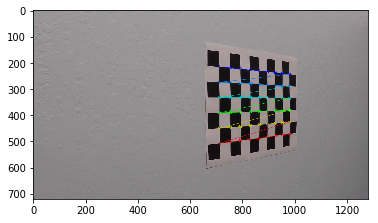

In [4]:
import glob
images = glob.glob('/Users/kathan/udacity/Term-1/CarND-Term1-Starter-Kit/Advance Lane Finding/CarND-Advanced-Lane-Lines-master/camera_cal/calibration*.jpg')

objpoints = [] #3D points in real world space
imgpoints = [] #2D points in image plane
nx = 6 #enter the number of inside corners in x
ny = 9 #enter the number of inside corners in y


#Prepare object points like (0,0,0),(1,0,0) etc..
objp = np.zeros((6*9,3),np.float32)
#Third column will always be zero. No need to change. Need to populate x and y column. Use mgrid of numpy.
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)#x,y coordinate

#Now we have to create image points. For that we have to detect the corners of the board.

for fname in images:
    #print (fname)
    
    image = cv2.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    #If there is any corner point then append it to image point array.
    #Also add prepared obj points to object point array
    #These object points are same for for all of the calibration images as they represent  read chessboard
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        #Display these corner points on an image
        cv2.drawChessboardCorners(image, (9, 6), corners, ret)
        plt.imshow(image)


    

In [5]:
print (len(imgpoints))
print (len(objpoints))

17
17


In [6]:
#Calibration of camera using object points and image points. It retruns camera matrix and distortion coeff in mtx
#and dist variable resp.
#rvecs and tvecs containts position of camera in real world
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [7]:
#Now undistort an image and check it
img = mpimg.imread('/Users/kathan/udacity/Term-1/CarND-Term1-Starter-Kit/Advance Lane Finding/CarND-Advanced-Lane-Lines-master/camera_cal/calibration2.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

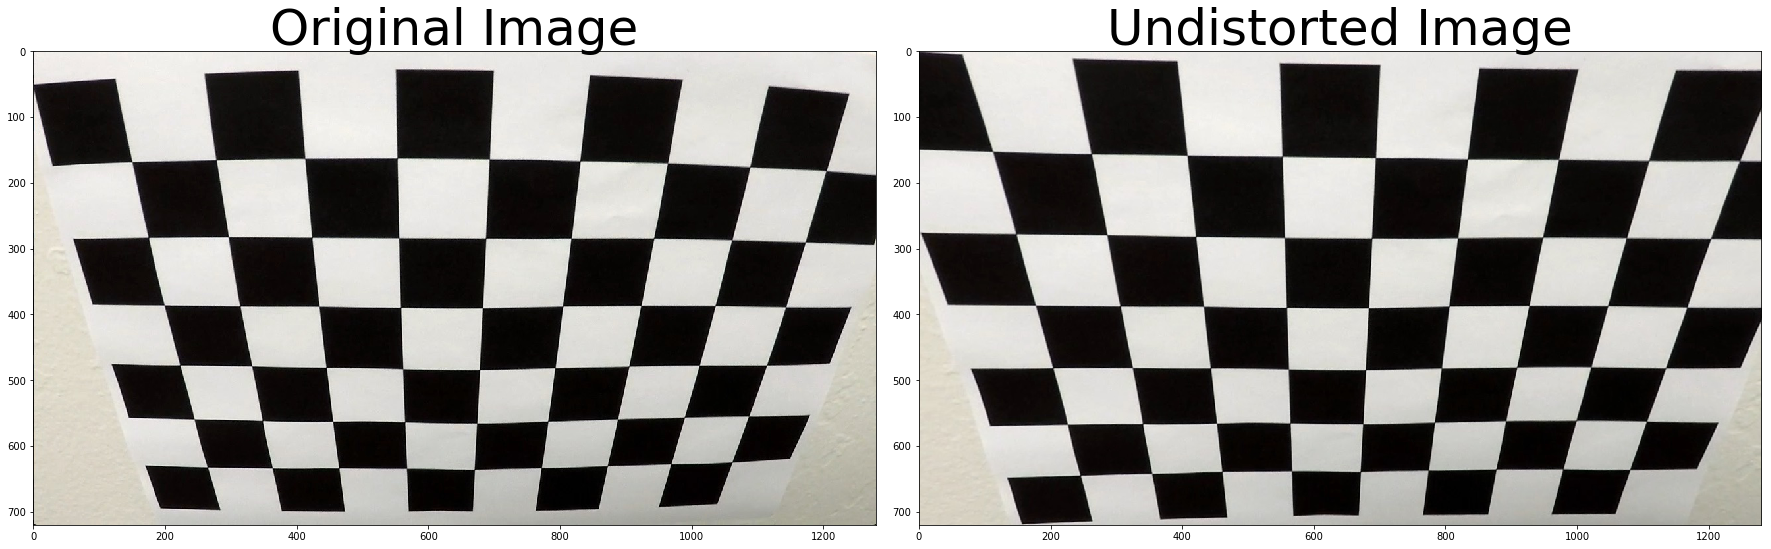

In [8]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [9]:
cv2.imwrite("Original.jpg",img)

True

In [10]:
cv2.imwrite("Undistorted.jpg",dst)

True

## PART 2: PIPELINE Functoins

In [123]:
#Undistort an image

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension


def undistort_image(img,mat,dist):
    return cv2.undistort(img,mat,dist,None,mat)

#Color and x gradient thresholding
def threshold_image(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    hsv1 = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    h_hsv_channel1 = hsv1[:,:,0]
    s_hsv_channel1 = hsv1[:,:,1]
    v_hsv_channel1 = hsv1[:,:,2]

    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray1 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx1 = cv2.Sobel(gray1, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx1 = np.absolute(sobelx1) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel1 = np.uint8(255*abs_sobelx1/np.max(abs_sobelx1))

    # Threshold x gradient
    #thresh_min1 = 24
    #thresh_max1 = 110
    #thresh_min1 = 40
    #thresh_max1 = 100
    thresh_min1 = 30
    thresh_max1 = 100
    
    sxbinary1 = np.zeros_like(scaled_sobel1)
    sxbinary1[(scaled_sobel1 >= thresh_min1) & (scaled_sobel1 <= thresh_max1)] = 1

    # Threshold color channel
    #s_thresh_min1 = 165
    #s_thresh_max1 = 254
    #s_thresh_min1 = 160
    #s_thresh_max1 = 254
    s_thresh_min1 = 220
    s_thresh_max1 = 254
    
    
    s_binary1 = np.zeros_like(s_channel)
    #s_binary1[(s_channel >= s_thresh_min1) & (s_channel <= s_thresh_max1)] = 1
    s_binary1[(r >= s_thresh_min1) & (r <= s_thresh_max1)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary1 = np.dstack(( np.zeros_like(sxbinary1), sxbinary1, s_binary1)) * 255

    # Combine the two binary thresholds
    combined_binary1 = np.zeros_like(sxbinary1)
    combined_binary1[(s_binary1 == 1) | (sxbinary1 == 1)] = 1
    
    return combined_binary1,color_binary1

#Perspective transformation
def transform_image(img):
    
    src_points = np.float32([[705,460],[1110,720],[205,720],[580,460]])
    dst_points = np.float32([[960,0],[960,720],[320,720],[320,0]])
    img_size = (img.shape[1],img.shape[0])
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    Minv = cv2.getPerspectiveTransform(dst_points,src_points)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped,Minv

#Find Region of Interest
def mask_image(img):
    vertices = np.array([[(100,720),(200,0), (1150, 0), (1200,720)]], dtype=np.int32)
    #defining a blank mask to start with
    mask = np.zeros_like(img)   

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    #plt.imshow(masked_image)
    return masked_image

#Use Histogram method to find lane lines
def find_histogram(img):
    histogram = np.sum(img[img.shape[0]//2 - 60:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    print (midpoint)

    leftx_base = np.argmax(histogram[:midpoint])
    print (leftx_base)

    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    print (rightx_base)
    
    return histogram,midpoint,leftx_base,rightx_base


def find_lanes(img,out_img,leftx_base,rightx_base):
    #Choose the number of sliding windows
    nwindows = 9

    #Set height of windows
    window_height = np.int(img.shape[0]/nwindows)

    #Identify x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 78
    # Set minimum number of pixels found to recenter window
    #minpix = 50
    minpix = 10
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #CURVATURE
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')

    #Find the center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_cr[0]*yMax**2 + left_fit_cr[1]*yMax + left_fit_cr[2]
    lineRight = right_fit_cr[0]*yMax**2 + right_fit_cr[1]*yMax + right_fit_cr[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter


    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return left_fitx,right_fitx,left_fit_cr,right_fit_cr,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,ploty,left_curverad,right_curverad,diffFromVehicle

#Visulizing lane lines
def visualize_lane_lines(img,out_img,left_fitx,right_fitx,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,ploty):
    # Create an image to draw on and an image to show the selection window
    #margin = 100
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

#Merging with original image for final output image
def merged_image(img,original,Minv,left_fitx,right_fitx,ploty,left_curverad,right_curverad,diffFromVehicle):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)

    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 2
    fontColor = (255, 0, 0)
    cv2.putText(result, 'Left curvature is: {:.0f} m'.format(left_curverad), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(result, 'Right curvature is: {:.0f} m'.format(right_curverad), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(result, 'Vehicle is {} of center'.format(message), (50, 190), font, fontScale, fontColor, 2)
    #plt.imshow(result)
    return result
    
    


## PART 3 : Pipeline for an Image

(720, 1280, 3)


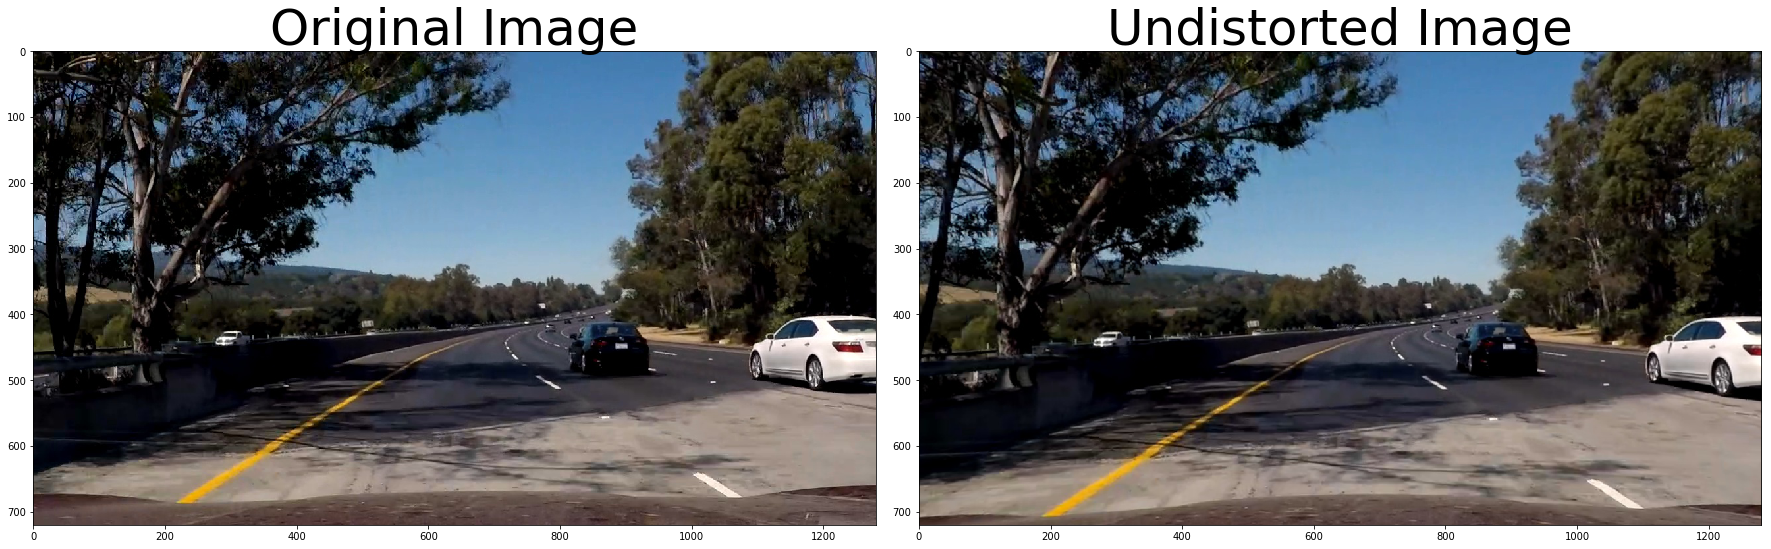

In [124]:
#test1 = mpimg.imread('/Users/kathan/udacity/Term-1/CarND-Term1-Starter-Kit/Advance Lane Finding/CarND-Advanced-Lane-Lines-master/test_images/test4.jpg')
test1 = mpimg.imread('/Users/kathan/udacity/Term-1/CarND-Term1-Starter-Kit/Advance Lane Finding/CarND-Advanced-Lane-Lines-master/frames/frame1034.jpg')
print (test1.shape)


#test_dst = cv2.undistort(test1, mtx, dist, None, mtx)
test_dst = undistort_image(test1,mtx,dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

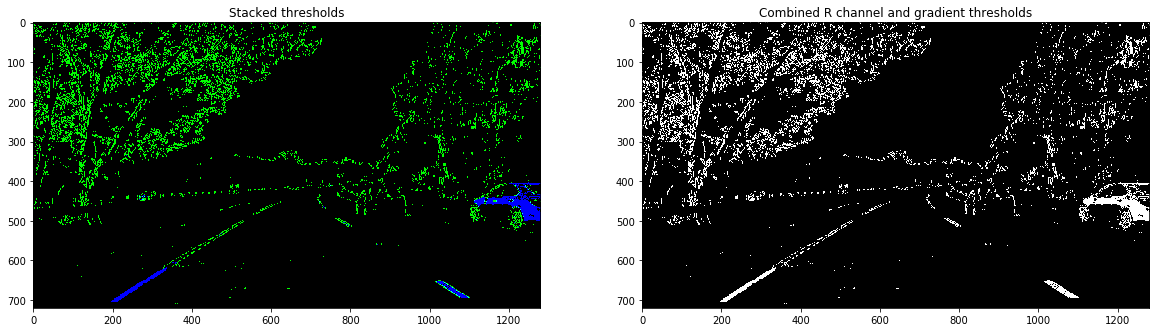

In [150]:

combined,color = threshold_image(test_dst)
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color)
ax2.set_title('Combined R channel and gradient thresholds')
ax2.imshow(combined, cmap='gray')



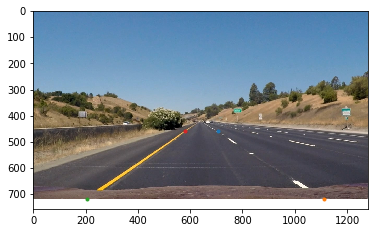

In [126]:
straight_image = mpimg.imread('/Users/kathan/udacity/Term-1/CarND-Term1-Starter-Kit/Advance Lane Finding/CarND-Advanced-Lane-Lines-master/test_images/straight_lines1.jpg')

plt.imshow(straight_image)
plt.plot(705,460,'.') #Top right
plt.plot(1110,720,'.') #Bottom right
plt.plot(205,720,'.') #Bottom left
plt.plot(580,460,'.') #Top left




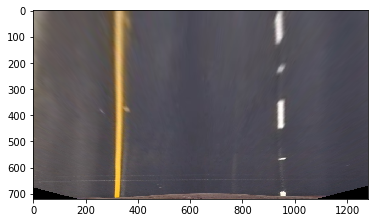

In [127]:
straight_image_dst = cv2.undistort(straight_image, mtx, dist, None, mtx)
src_points = np.float32([[705,460],[1110,720],[205,720],[580,460]])
##src_points = np.float32([[695,460],[1127,720],[203,720],[585,460]])
dst_points = np.float32([[960,0],[960,720],[320,720],[320,0]])
##dst_points = np.float32([[960,0],[960,720],[320,720],[320,0]])

img_size = (straight_image.shape[1],straight_image.shape[0])
M1 = cv2.getPerspectiveTransform(src_points, dst_points)
Minv1 = cv2.getPerspectiveTransform(dst_points,src_points)
straight_warped = cv2.warpPerspective(straight_image_dst, M1, img_size, flags=cv2.INTER_LINEAR)

plt.imshow(straight_warped)




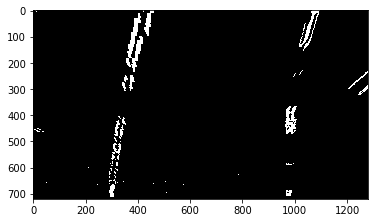

In [128]:
#Perspective Transformation
warped_image,Minv = transform_image(combined)
plt.imshow(warped_image,cmap='gray')



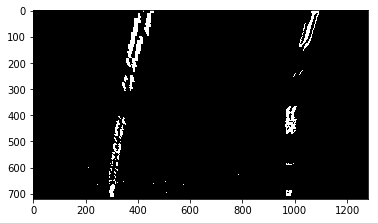

In [129]:
#Masking an image
masked_image = mask_image(warped_image)
plt.imshow(masked_image,cmap="gray")

640
321
978


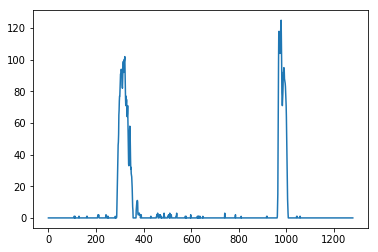

In [130]:
#Find Histogram
histogram_image,midpoint,leftx_base,rightx_base = find_histogram(masked_image)
plt.plot(histogram_image)

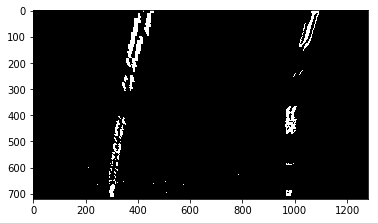

In [131]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((masked_image, masked_image, masked_image))*255

plt.imshow(out_img)



3268.53647257 1681.5119563
1065.99614903 m 547.403491881 m


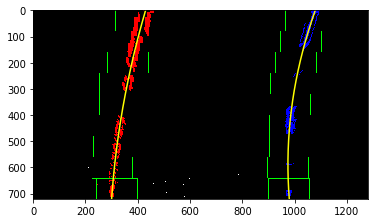

In [132]:
#Visualization of sliding window image
left_fitx,right_fitx,left_fit_cr,right_fit_cr,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,ploty,left_curverad,right_curverad,diffFromVehicle = find_lanes(masked_image,out_img,leftx_base,rightx_base)

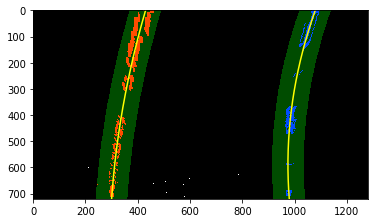

In [133]:

visualize_lane_lines(masked_image,out_img,left_fitx,right_fitx,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,ploty)

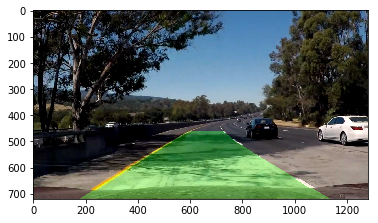

In [134]:
#Final output
final_image = merged_image(masked_image,test1,Minv,left_fitx,right_fitx,ploty,left_curverad,right_curverad,diffFromVehicle)

In [135]:
##Code to Store video in frames

#import cv2
#vidcap = cv2.VideoCapture('project_video.mp4')
#success,image = vidcap.read()
#count = 0
#success = True
#while success:
#    success,image = vidcap.read()
#    print('Read a new frame: ', success)
#    cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
#    count += 1

## PIPELINE for Video

In [146]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.left_fitx = None
        self.right_fitx = None
        self.left_fit_cr = None
        self.right_fit_cr = None
        self.radius_of_curvature = None        
        self.line_base_pos = None
        self.left_cureverad = None
        self.right_curverad = None
leftLane = Line()
rightLane = Line()
    
def process_image(img):
    undist = undistort_image(img,mtx,dist)
    combined,color = threshold_image(undist)
    
    warped_image,Minv = transform_image(combined)
    masked_image = mask_image(warped_image)
    histogram_image,midpoint,leftx_base,rightx_base = find_histogram(masked_image)  
    out_img = np.dstack((warped_image, warped_image, warped_image))*255
    left_fitx,right_fitx,left_fit_cr,right_fit_cr,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,ploty,left_curverad,right_curverad,diffFromVehicle = find_lanes(warped_image,out_img,leftx_base,rightx_base)
    if left_curverad > 10000:
        left_fitx = leftLane.left_fitx
        left_fit_cr = leftLane.left_fit_cr
        left_curverad = leftLane.left_curverad
    else:
        leftLane.left_fitx = left_fitx
        leftLane.left_fit_cr = left_fit_cr
        leftLane.left_curverad = left_curverad

    if right_curverad > 10000:
        right_fitx = rightLane.right_fitx
        right_fit_cr = rightLane.right_fit_cr
        right_curverad = rightLane.right_curverad
    else:
        rightLane.right_fitx = right_fitx
        rightLane.right_fit_cr = right_fit_cr
        rightLane.right_curverad = right_curverad
            
    final_result = merged_image(warped_image,img,Minv,left_fitx,right_fitx,ploty,left_curverad,right_curverad,diffFromVehicle)
    return final_result
    
    
    

In [147]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

640
364
1022
1932.49596388 2600.27290127
631.72839236 m 852.77293997 m
[MoviePy] >>>> Building video output_video/project_video_output_trial10_red_channel_all.mp4
[MoviePy] Writing video output_video/project_video_output_trial10_red_channel_all.mp4



  0%|          | 0/1261 [00:00<?, ?it/s]

640
364
1022


  0%|          | 1/1261 [00:00<03:37,  5.79it/s]


1932.49596388 2600.27290127
631.72839236 m 852.77293997 m


640
366
1001
1860.24526534 2889.74600293
607.451561667 m 945.330642341 m



  0%|          | 2/1261 [00:00<03:40,  5.72it/s]

640
367
1004
1860.40216208 1922.17642284
607.718941522 m 631.211823489 m



  0%|          | 3/1261 [00:00<03:31,  5.94it/s]

640
368
972
1871.87322469 1928.73312381
612.05794285 m 632.865576001 m



  0%|          | 4/1261 [00:00<03:22,  6.22it/s]

640
369
958
2112.11984073 2106.47481691
693.157844178 m 689.98143277 m



  0%|          | 5/1261 [00:00<03:18,  6.32it/s]

640
367
969
2036.48034568 2684.24951575
668.198935689 m 873.201471736 m



  0%|          | 6/1261 [00:00<03:15,  6.43it/s]

640
368
969
2012.36626044 3170.97150222
660.439702945 m 1027.2114906 m



  1%|          | 7/1261 [00:01<03:15,  6.43it/s]

640
374
970
2054.70498542 76773.6854962
674.659427902 m 23109.1485828 m



  1%|          | 8/1261 [00:01<03:10,  6.56it/s]

640
371
976
2132.80878748 14107.1251922
700.521795352 m 4182.2809765 m



  1%|          | 9/1261 [00:01<03:12,  6.49it/s]

640
372
980
2302.16348175 72021.5762245
756.014873705 m 21839.2318457 m



  1%|          | 10/1261 [00:01<03:16,  6.37it/s]

640
369
1002
2455.73470843 7804.55495026


  1%|          | 11/1261 [00:01<03:28,  5.98it/s]


806.025009488 m 2448.08500748 m
640
368
1012
2663.21897551 6628.41116106
872.070262994 m 2116.27487723 m



  1%|          | 13/1261 [00:02<03:16,  6.36it/s]

640
369
1001
2723.57570828 7769.70917395
891.71452962 m 2460.56987983 m
640
363
996
2918.22863355 6982.40838233
954.267492797 m 2215.21843156 m



  1%|          | 15/1261 [00:02<03:11,  6.52it/s]

640
368
1003
2381.52795837 3103.96993572
781.770079457 m 1000.71038036 m
640
365
1008
3015.45645227 2254.38566426
986.99125427 m 731.336312986 m



  1%|▏         | 17/1261 [00:02<03:12,  6.45it/s]

640
367
941
2930.07012859 2622.77583113
959.074572225 m 847.285645693 m
640
370
943
2796.59934062 3517.29009226
915.818648499 m 1121.25647639 m



  2%|▏         | 19/1261 [00:02<03:08,  6.60it/s]

640
369
962
3234.65000922 3858.05808762
1056.83778575 m 1230.27950919 m
640
369
970
3577.08019047 4812.72034239
1165.53590701 m 1528.73089025 m



  2%|▏         | 21/1261 [00:03<03:07,  6.60it/s]

640
341
979
3517.72785131 9217.4061397
1146.53889071 m 2879.50322296 m
640
340
988
3742.40947368 9909.70351835
1217.3636093 m 3114.936318 m



  2%|▏         | 23/1261 [00:03<03:02,  6.77it/s]

640
339
994
3829.51678825 8292.76351275
1245.68883057 m 2634.31570313 m
640
339
998
3303.20212679 3691.51906324
1079.31982364 m 1195.39286147 m



  2%|▏         | 25/1261 [00:03<03:17,  6.27it/s]

640
340
1000
3318.63654751 2690.44726982
1084.8619482 m 877.793141188 m
640
343
993
3321.64464884 


  2%|▏         | 26/1261 [00:04<03:25,  6.02it/s]

3064.99371597
1086.53582462 m 999.650616948 m
640
340
990
2668.27395924 4193.10264707
875.758911707 m 1357.46947214 m



  2%|▏         | 28/1261 [00:04<03:13,  6.38it/s]

640
331
1001
2549.33945113 3724.42956738
837.092048905 m 1214.76038915 m
640
336
1000
2666.48656118 3217.23109037
875.4882866 m 1050.55949218 m



  2%|▏         | 30/1261 [00:04<03:12,  6.40it/s]

640
342
1015
2507.08436806 1962.78224612
823.387807168 m 644.059016773 m
640
346
953
2280.05949386 2324.82158195
748.820380711 m 759.266507393 m



  3%|▎         | 32/1261 [00:05<03:12,  6.39it/s]

640
350
952
2120.65379948 2780.74694081
696.045090324 m 899.915198233 m
640
350
971
2165.28129469 4059.4196065
710.840882304 m 1298.36065841 m



  3%|▎         | 34/1261 [00:05<03:22,  6.07it/s]

640
352
963
2084.27726278 30722.4044015
683.950431344 m 9325.68646569 m
640
353
990
1981.21924185 9996.16171106
649.66874471 m 3094.27445237 m



  3%|▎         | 36/1261 [00:05<03:14,  6.31it/s]

640
355
969
1930.91099146 3037.62253799
632.975734281 m 978.587777562 m
640
357
996
1780.48816206 2946.97182902
582.690277032 m 950.418082858 m



  3%|▎         | 38/1261 [00:05<03:07,  6.52it/s]

640
358
988
1708.31527211 3859.56528565
558.561132385 m 1228.40671064 m
640
360
984
1644.02099617 1935.80784396
536.959654553 m 631.61473346 m



  3%|▎         | 40/1261 [00:06<03:07,  6.52it/s]

640
360
1006
1637.06343793 1599.56813718
534.82107682 m 524.435876462 m
640
360
989
1588.00397338 1908.7223309
518.520070314 m 622.545533326 m



  3%|▎         | 42/1261 [00:06<03:15,  6.22it/s]

640
361
941
1550.59964623 2189.70086619
506.470996651 m 711.19969985 m
640
361
944
1624.51443307 1956.10454348
532.136899929 m 637.619297694 m



  3%|▎         | 44/1261 [00:06<03:13,  6.30it/s]

640
362
950
1699.64729728 2196.83643166
557.577328 m 715.111750728 m
640
361
956
1819.4544504 2611.15824949
597.485131456 m 845.444132947 m



  4%|▎         | 46/1261 [00:07<03:11,  6.33it/s]

640
361
960
1876.1765365 5653.68765061
616.232107854 m 1767.95611717 m
640
358
990
1951.1996364 5014.8482969
640.802336129 m 1581.88963019 m



  4%|▍         | 48/1261 [00:07<03:16,  6.18it/s]

640
361
990
2018.54280539 6475.13248936
662.768040106 m 2021.47824121 m
640
358
998
2175.84021831 5563.55971381
713.749377811 m 1759.6242817 m



  4%|▍         | 50/1261 [00:07<03:13,  6.25it/s]

640
361
1002
2348.83569419 2372.23965925
769.150530189 m 771.958816754 m
640
361
988
2612.8619101 3286.13985049
853.409798873 m 1056.88089639 m



  4%|▍         | 52/1261 [00:08<03:12,  6.29it/s]

640
362
1004
2704.25156142 3538.41762226
882.442594715 m 1132.10461488 m
640
363
1007
2537.07179919 2036.94873487
829.866374485 m 663.875400388 m



  4%|▍         | 54/1261 [00:08<03:07,  6.45it/s]

640
363
1010
2767.92664117 1973.18939387
903.673547655 m 642.273791086 m
640
356
933
3274.38983466 1963.71393074
1063.67917061 m 640.88766132 m



  4%|▍         | 56/1261 [00:08<03:07,  6.43it/s]

640
355
941
3733.28048172 2223.95386843
1209.25271878 m 722.24575612 m
640
355
953
3715.2686497 2572.93590161
1204.45124981 m 829.277562952 m



  5%|▍         | 58/1261 [00:09<03:10,  6.33it/s]

640
330
953
3831.45256486 4510.01322178
1242.21948796 m 1414.96191697 m
640
340
955
3809.8300347 12271.5108374
1238.32205448 m 3669.38212956 m



  5%|▍         | 60/1261 [00:09<03:05,  6.46it/s]

640
341
958
3276.85023174 3820.31563244
1070.2172819 m 1194.3260009 m
640
343
976
2840.07651889 5389.15807232
930.372395601 m 1660.41506067 m



  5%|▍         | 62/1261 [00:09<03:07,  6.41it/s]

640
343
966
2595.83168159 4107.58609759
851.743973501 m 1278.31230213 m
640
345
975
2541.37127218 3623.82117253
834.160875242 m 1140.54620299 m



  5%|▌         | 64/1261 [00:10<03:06,  6.42it/s]

640
347
986
2395.25170367 2097.80985369
786.681105568 m 677.041008368 m
640
348
992
2226.65248145 2485.00870177
731.300138542 m 799.227981488 m



  5%|▌         | 66/1261 [00:10<03:42,  5.38it/s]

640
346
995
2238.23261103 2705.09258125
735.039087134 m 865.178265103 m



  5%|▌         | 67/1261 [00:10<03:31,  5.64it/s]

640
348
914
2177.28629207 2716.69293775
714.918227453 m 873.601213078 m
640
344
923
2454.4641198 3131.00188278
806.123213057 m 1003.82187139 m



  5%|▌         | 69/1261 [00:10<03:16,  6.07it/s]

640
349
924
2415.60363551 4051.42839831
793.407873614 m 1284.52757925 m
640
346
931
2534.8626941 5661.34610823
832.421922616 m 1782.85109159 m



  6%|▌         | 71/1261 [00:11<03:08,  6.31it/s]

640
347
936
2660.82103851 9058.34225963
873.56187012 m 2801.89443166 m
640
346
941
2915.45203322 3241.31563424
956.244304124 m 1044.67999138 m



  6%|▌         | 73/1261 [00:11<03:05,  6.40it/s]

640
345
944
3276.89668398 2561.11973579
1073.23464949 m 833.697093689 m
640
345
949
3587.35127746 3561.77620257
1173.63412664 m 1146.60635114 m



  6%|▌         | 75/1261 [00:11<03:07,  6.34it/s]

640
343
956
4364.43320353 4014.4132098
1422.4745506 m 1292.48650238 m
640
345
960
4558.59329163 3177.6714576
1485.93865665 m 1029.68954225 m



  6%|▌         | 77/1261 [00:12<03:09,  6.25it/s]

640
333
968
5100.04221798 3379.69602408
1658.31309364 m 1098.67877368 m
640
325
972
6182.36478836 2060.54629077
2004.34356227 m 676.425304994 m



  6%|▋         | 79/1261 [00:12<03:07,  6.29it/s]

640
325
974
5773.47930017 1760.82798579
1875.22233488 m 578.325297753 m
640
322
978
5734.15059632 1873.20341065
1864.92306735 m 615.233289745 m



  6%|▋         | 81/1261 [00:12<03:08,  6.28it/s]

640
322
931
6457.87222653 2223.68431644
2098.35081163 m 728.566427999 m
640
322
934
7304.10869415 2350.10362655
2372.38002578 m 769.488375413 m



  7%|▋         | 83/1261 [00:13<03:05,  6.37it/s]

640
319
941
5868.54624532 3092.70476601
1912.43840808 m 1005.3764079 m
640
315
951
5550.78717943 4678.61388695
1809.02301014 m 1508.7062246 m



  7%|▋         | 85/1261 [00:13<03:02,  6.43it/s]

640
316
956
4994.89282675 10043.521457
1631.70739258 m 3183.6130368 m
640
319
959
4154.50844441 23544.4735398
1360.99410801 m 7395.36884879 m



  7%|▋         | 87/1261 [00:13<03:28,  5.63it/s]

640
326
959
3264.13639193 3253.2351694
1072.06303196 m 1054.67605522 m
640
329
959



  7%|▋         | 88/1261 [00:14<03:28,  5.62it/s]

2813.00016061 7499.60090457
923.5197063 m 2373.94051741 m
640
332
969
2544.37341426 3197.99881099
834.084392685 m 1034.01435261 m



  7%|▋         | 90/1261 [00:14<03:29,  5.59it/s]

640
334
962
2317.6020278 2092.1436361
757.890154875 m 682.904268585 m
640
332
969
2216.09725866 2274.63139019
724.007294275 m 741.792962316 m



  7%|▋         | 92/1261 [00:14<03:15,  5.99it/s]

640
334
973
2188.42294054 2522.8803354
715.124218179 m 821.329206422 m
640
335
920
2176.79599925 2823.55460893
711.444435235 m 915.051922171 m



  7%|▋         | 94/1261 [00:15<03:21,  5.78it/s]

640
337
924
2200.99198764 3266.21239121
719.6065441 m 1053.4704453 m
640
336
931
2271.57308237 3476.88966645
743.714901277 m 1123.48312505 m



  8%|▊         | 96/1261 [00:15<03:13,  6.03it/s]

640
336
935
2320.7186909 5662.84960767
760.345069858 m 1798.78320182 m
640
337
952
2339.39237864 5410.80867603
766.869437724 m 1724.65120582 m



  8%|▊         | 98/1261 [00:15<03:08,  6.17it/s]

640
337
966
2392.65922582 3066.30242862
784.749366068 m 999.06969818 m
640
339
950
2476.34679613 3231.9529372
812.539035017 m 1050.01178546 m



  8%|▊         | 100/1261 [00:16<03:07,  6.19it/s]

640
339
956
2502.21609896 3129.68341506
821.237351027 m 1020.00195848 m
640
340
958
2435.09833109 2968.4457443
798.979821846 m 968.357927976 m



  8%|▊         | 102/1261 [00:16<03:06,  6.22it/s]

640
342
961
2418.25996238 2341.45629097
793.210778323 m 766.956355613 m
640
342
983
2381.0960499 1858.00916505
780.92407027 m 610.202496221 m



  8%|▊         | 104/1261 [00:16<03:03,  6.32it/s]

640
344
969
2371.22118394 1958.943066
777.66601278 m 643.045182703 m
640
343
990
2514.37184962 2130.66887112
825.36394384 m 699.395680059 m



  8%|▊         | 106/1261 [00:16<03:01,  6.37it/s]

640
343
960
2687.63047356 2297.02957017
882.693817481 m 753.942831724 m
640
344
967
2585.1446975 2464.08364368
848.972971487 m 808.616898085 m



  9%|▊         | 108/1261 [00:17<03:01,  6.36it/s]

640
346
969
2406.90379258 2707.02855403
789.971115725 m 886.178170698 m
640
346
974
2446.22650981 6533.10228112
802.944359503 m 2084.97403125 m



  9%|▊         | 110/1261 [00:17<03:01,  6.33it/s]

640
349
979
2449.3535833 8795.03717361
803.870195189 m 2797.73006587 m
640
347
984
2341.83004984 6488.87713945
768.343556002 m 2079.20940763 m



  9%|▉         | 112/1261 [00:17<03:07,  6.12it/s]

640
346
972
2490.52223675 4368.61024963
817.750791628 m 1420.55696192 m
640
349
973
2245.78515804 2833.81559892
736.474698787 m 927.35607689 m



  9%|▉         | 114/1261 [00:18<03:02,  6.27it/s]

640
349
978
2197.35938063 2993.35285546
720.250367246 m 978.030980326 m
640
350
980
1969.16484843 2103.21505701
643.676452403 m 690.167271397 m



  9%|▉         | 116/1261 [00:18<03:01,  6.30it/s]

640
351
1000
1952.37361137 1597.65168253
638.038597777 m 524.623481974 m
640
351
985
1957.62723065 1804.57652318
640.120053908 m 592.579700501 m



  9%|▉         | 118/1261 [00:18<03:09,  6.03it/s]

640
352
937
2063.81305971 1901.01598803
676.25568377 m 623.798221533 m
640
353
941
2142.99739505 1941.21354603
702.695433291 m 636.582200833 m



 10%|▉         | 120/1261 [00:19<03:14,  5.86it/s]

640
355
943
2021.86321659 2194.96540839
662.341614912 m 716.465647825 m
640
356
952
2072.09921532 2539.76522061
679.385087213 m 825.673388018 m



 10%|▉         | 122/1261 [00:19<03:10,  5.99it/s]

640
357
958
1968.85552018 2800.51297047
645.099583074 m 904.326175566 m
640
358
961
1945.96099629 1984.89312103
637.464185893 m 648.969612037 m



 10%|▉         | 124/1261 [00:19<03:04,  6.17it/s]

640
359
966
1905.28068003 2414.65335756
623.868334201 m 783.388624746 m
640
361
982
1869.95992922 2382.90875181
612.227997322 m 772.553637498 m



 10%|▉         | 126/1261 [00:20<03:02,  6.22it/s]

640
360
994
2052.99071223 3233.44095985
673.685930869 m 1040.80180985 m
640
361
982
1971.27585996 1564.52158768
646.508455196 m 513.643651797 m



 10%|█         | 128/1261 [00:20<03:02,  6.20it/s]

640
362
1005
1944.68585702 1679.20634296
637.728127718 m 550.960321179 m
640
364
989
1859.64667167 1904.67522939
609.339454562 m 621.169798451 m



 10%|█         | 130/1261 [00:20<03:00,  6.26it/s]

640
364
991
2031.87557771 2026.85772967
666.907982632 m 660.226680469 m
640
365
938
2183.38149547 2185.1353049
717.101742995 m 709.450211639 m



 10%|█         | 132/1261 [00:21<03:01,  6.21it/s]

640
365
949
2163.47281732 2412.81339996
710.537651658 m 778.410746115 m
640
366
957
2259.2984664 2489.59854883
742.073951496 m 804.526992842 m



 11%|█         | 134/1261 [00:21<03:01,  6.19it/s]

640
368
967
2214.62100867 2891.22692148
727.393732873 m 922.60533596 m
640
369
969
2314.57666072 2330.86736319
760.211117419 m 755.169964856 m



 11%|█         | 136/1261 [00:21<02:59,  6.28it/s]

640
370
974
2225.49311272 3308.23387775
730.970148579 m 1057.17429152 m
640
367
992
2384.93111513 3924.70296305
783.21770477 m 1250.88009446 m



 11%|█         | 138/1261 [00:22<02:55,  6.40it/s]

640
366
1002
2424.10152334 4567.21072669
796.044916157 m 1457.48676057 m
640
366
988
2374.06120218 7388.28994912
779.724770109 m 2325.56386185 m



 11%|█         | 140/1261 [00:22<02:51,  6.52it/s]

640
366
995
2493.26092328 6944.84475141
818.694891418 m 2210.3519708 m
640
366
1015
2441.07426371 2864.37182932
801.705485591 m 930.79195601 m



 11%|█▏        | 142/1261 [00:22<02:50,  6.57it/s]

640
366
1017
2478.59523938 2388.45039282
814.054630969 m 779.407740605 m
640
354
946
2865.67455021 2814.13750911
940.374632339 m 911.629279684 m



 11%|█▏        | 144/1261 [00:23<02:54,  6.40it/s]

640
356
946
2668.13468731 3213.18037327
876.081151136 m 1037.66750078 m
640
358
953
2865.53275521 3771.50507623
940.551573564 m 1212.89839862 m



 12%|█▏        | 146/1261 [00:23<02:56,  6.33it/s]

640
362
960
3040.95674603 5496.56044522
998.022571977 m 1742.19873117 m
640
361
961
2969.00661125 7677.31010178
974.474476384 m 2417.46881752 m



 12%|█▏        | 148/1261 [00:23<02:56,  6.30it/s]

640
365
964
2902.39173958 2868.12341155
953.087271355 m 926.408074907 m
640
365
962
2759.97071562 2942.23845078
906.510557219 m 950.017227461 m



 12%|█▏        | 150/1261 [00:24<02:58,  6.21it/s]

640
365
972
2887.9421462 3337.41691707
948.402202373 m 1077.5186868 m
640
360
976
2959.8448527 2518.01776768
971.89067992 m 821.606135894 m



 12%|█▏        | 152/1261 [00:24<02:58,  6.22it/s]

640
360
985
2948.46952339 1945.14479081
968.172176753 m 638.385594042 m
640
362
988
2777.7397558 1700.01233946
912.347281459 m 558.115134922 m



 12%|█▏        | 154/1261 [00:24<02:55,  6.30it/s]

640
362
992
2991.05945341 1848.55623383
982.068863721 m 606.63019123 m
640
351
1013
2904.31960363 2122.13488869
953.415580567 m 695.052568058 m



 12%|█▏        | 156/1261 [00:24<02:55,  6.30it/s]

640
352
970
2913.63875939 2312.9475446
956.501211243 m 755.964001802 m
640
350
948
2892.0870813 2628.65464661
949.393739243 m 855.900136631 m



 13%|█▎        | 158/1261 [00:25<02:51,  6.42it/s]

640
352
965
2794.50483762 3228.58418265
917.707786986 m 1040.84907651 m
640
349
958
2794.18441645 8796.09659789
917.505740387 m 2725.13614991 m



 13%|█▎        | 160/1261 [00:25<02:55,  6.26it/s]

640
349
970
2622.78085932 6458.54076341
861.425961678 m 2015.67008004 m
640
348
986
2628.68789925 5615.73193148
863.249523001 m 1774.17135169 m



 13%|█▎        | 162/1261 [00:25<02:54,  6.29it/s]

640
351
974
2589.82441733 5018.38656444
850.416757964 m 1596.04788636 m
640
349
988
2640.98988562 8294.51510957
867.050222764 m 2615.61700146 m



 13%|█▎        | 164/1261 [00:26<02:53,  6.31it/s]

640
349
989
2463.46040469 10167.3939787
809.082480542 m 3174.09588503 m
640
351
988
2249.88294875 2270.71718074
738.876957739 m 738.090492334 m



 13%|█▎        | 166/1261 [00:26<02:53,  6.30it/s]

640
351
986
2315.22564887 2451.72449906
760.443514929 m 795.187347906 m
640
351
1004
2315.74989298 2721.25576298
760.603778296 m 875.509192239 m



 13%|█▎        | 168/1261 [00:26<02:52,  6.33it/s]

640
346
930
2548.16229251 2588.98929225
836.391892696 m 840.830397178 m
640
349
938
2708.84677163 2890.69789069
888.286449155 m 935.438109518 m



 13%|█▎        | 170/1261 [00:27<02:52,  6.31it/s]

640
342
945
3070.30896279 3222.96027511
1004.6558794 m 1043.897237 m
640
345
951
3195.61387253 3322.6599642
1044.7944563 m 1076.4394231 m



 14%|█▎        | 172/1261 [00:27<02:51,  6.36it/s]

640
344
954
3242.13038456 3154.53055272
1059.50375029 m 1023.5100577 m
640
343
977
3219.00037443 1831.15573674
1052.86584716 m 601.396159289 m



 14%|█▍        | 174/1261 [00:27<02:49,  6.40it/s]

640
345
974
2835.10466057 1604.36969093
929.548691235 m 526.9600738 m
640
342
979
2871.94762996 1271.88276604
941.782182797 m 416.842884391 m



 14%|█▍        | 176/1261 [00:28<02:51,  6.32it/s]

640
341
964
2665.38382768 1048.26928641
874.88198248 m 340.258404767 m
640
327
973
2715.59228006 1129.46327226
891.047039705 m 367.661164396 m



 14%|█▍        | 178/1261 [00:28<02:54,  6.20it/s]

640
337
997
2652.88447043 1163.40954535
870.713761433 m 379.876053642 m
640
329
1002
2685.56143875 1301.71256748
881.53651837 m 427.136072152 m



 14%|█▍        | 180/1261 [00:28<02:52,  6.25it/s]

640
329
988
2644.71393978 1404.82164579
868.180202054 m 461.322095416 m
640
337
942
2316.28278996 1482.20123992
760.771004206 m 486.633043153 m



 14%|█▍        | 182/1261 [00:29<02:50,  6.33it/s]

640
337
958
2253.03468391 1595.9647787
739.885526609 m 523.6350537 m
640
340
962
1962.03722089 1760.87857083
642.97292982 m 575.091936881 m



 15%|█▍        | 184/1261 [00:29<02:55,  6.14it/s]

640
339
965
1843.08482286 2051.89992621
602.6812712 m 660.897670333 m



 15%|█▍        | 185/1261 [00:29<03:08,  5.71it/s]

640
339
963
1751.74187426 1985.94070945
571.472013154 m 639.45362465 m
640
343
974
1591.64010579 1563.16205594
516.086789182 m 506.797154375 m



 15%|█▍        | 187/1261 [00:29<02:59,  5.98it/s]

640
343
979
1597.45306633 1397.22309666
518.275817449 m 455.833346883 m
640
344
978
1515.51963846 1837.57991329
490.293356686 m 587.062427667 m



 15%|█▍        | 189/1261 [00:30<02:55,  6.10it/s]

640
346
977
1525.21155545 1985.90683871
494.277158829 m 632.988745738 m
640
348
1000
1575.13877137 1830.49262248
512.095258054 m 586.138432347 m



 15%|█▌        | 191/1261 [00:30<02:54,  6.15it/s]

640
351
909
1533.51124178 1904.05368173
498.192653503 m 607.330668266 m
640
352
917
1736.81409473 2094.28875127
568.260069255 m 669.057311799 m



 15%|█▌        | 193/1261 [00:30<02:55,  6.08it/s]

640
355
925
1760.5253942 1900.76568834
576.607949923 m 610.211064445 m
640
357
935
1815.87321733 2001.20793382
595.270838483 m 640.234175979 m



 15%|█▌        | 195/1261 [00:31<02:54,  6.11it/s]

640
358
943
1832.56121215 1910.14365033
600.979825878 m 613.438639952 m
640
356
961
2153.45267029 2592.28800044
707.304620863 m 828.993333938 m



 16%|█▌        | 197/1261 [00:31<02:54,  6.08it/s]

640
353
965
2221.91596873 4744.34544966
729.584770562 m 1493.33718142 m
640
349
990
2376.11483935 9264.57168362
779.49255391 m 2900.98106703 m



 16%|█▌        | 199/1261 [00:31<02:53,  6.11it/s]

640
333
996
2637.14993687 7706.66456608
862.892741614 m 2455.57253898 m
640
333
1001
2759.63985335 4994.06425847
902.447428799 m 1605.05015972 m



 16%|█▌        | 201/1261 [00:32<02:50,  6.22it/s]

640
332
991
2926.3625699 2730.42556994
956.204890575 m 892.639963459 m
640
336
1007
2675.57328156 3815.16367878
876.557231773 m 1231.64588122 m



 16%|█▌        | 203/1261 [00:32<02:51,  6.18it/s]

640
341
1006
2527.63130565 3207.70080944
829.17118167 m 1038.25179308 m
640
340
1009
2609.99304217 1882.07987782
855.8906622 m 616.530512799 m



 16%|█▋        | 205/1261 [00:32<02:51,  6.17it/s]

640
341
935
2563.62193642 2087.84179949
841.073927034 m 680.839940155 m
640
342
946
2361.60714733 2228.54054175
775.385816058 m 723.772114617 m



 16%|█▋        | 207/1261 [00:33<02:47,  6.29it/s]

640
345
947
2266.1195154 2340.61224372
744.300425518 m 753.417884904 m
640
346
944
2210.21364371 2241.63396198
725.943910947 m 718.992303485 m



 17%|█▋        | 209/1261 [00:33<02:46,  6.32it/s]

640
346
962
2158.55096128 2695.76353743
708.968760811 m 858.196434241 m
640
344
960
2166.55788942 2577.84950725
711.612285485 m 828.867686887 m



 17%|█▋        | 211/1261 [00:33<02:45,  6.34it/s]

640
342
984
2269.17802801 2016.97070956
745.18694156 m 659.280509132 m
640
343
989
2180.65021112 2701.08593169
716.225710841 m 870.705260174 m



 17%|█▋        | 213/1261 [00:34<02:43,  6.43it/s]

640
341
977
2066.38237492 3221.1010198
678.693006414 m 1032.27076969 m
640
337
980
2015.57322398 3092.4204517
661.94490626 m 989.968473005 m



 17%|█▋        | 215/1261 [00:34<02:46,  6.29it/s]

640
340
997
1861.08283164 1980.48721436
610.861320972 m 644.409236522 m
640
335
1001
1861.43729749 1936.55590638
611.068288085 m 630.123208086 m



 17%|█▋        | 217/1261 [00:34<02:49,  6.15it/s]

640
340
918
1908.08164817 2312.02342767
626.643242444 m 748.876568725 m
640
339
927
2086.78420027 2406.32500231
685.2816098 m 779.111060807 m



 17%|█▋        | 219/1261 [00:35<02:45,  6.31it/s]

640
339
934
2118.45735538 3147.69833078
695.636238419 m 1002.18472591 m
640
337
939
2275.25210128 4465.98661549
746.304653918 m 1407.92199059 m



 18%|█▊        | 221/1261 [00:35<02:49,  6.14it/s]

640
338
950
2340.96041517 31263.3279815
767.240638292 m 9346.70281863 m
640
337
960
2438.13606718 14297.846933
798.478811141 m 4362.14111199 m



 18%|█▊        | 223/1261 [00:35<02:47,  6.20it/s]

640
339
965
2635.94688612 6335.92584517
861.650295281 m 1982.97900904 m
640
336
965
2553.87630354 5032.9881442
836.001420501 m 1578.55091518 m



 18%|█▊        | 225/1261 [00:36<02:46,  6.24it/s]

640
335
966
2497.56897522 5375.14739849
817.858255131 m 1689.11973315 m
640
334
968
2282.76485439 2600.37061518
749.110080978 m 838.224324747 m



 18%|█▊        | 227/1261 [00:36<02:46,  6.21it/s]

640
336
979
2341.24096457 2247.19793006
767.962724786 m 728.617976754 m
640
335
983
2508.65099903 2589.63297053
821.958253076 m 836.814899092 m



 18%|█▊        | 229/1261 [00:36<02:46,  6.21it/s]

640
335
982
2711.68696687 2875.14683271
886.881139406 m 926.741791913 m
640
330
915
2884.92928483 2739.21547242
941.806017263 m 888.398841592 m



 18%|█▊        | 231/1261 [00:37<02:44,  6.25it/s]

640
329
918
3113.03284517 2960.02381695
1015.17984143 m 955.414294501 m
640
315
922
3353.5594573 3121.39107921
1091.04441464 m 1009.75152228 m



 18%|█▊        | 233/1261 [00:37<02:45,  6.22it/s]

640
328
936
3624.0401806 3852.22197662
1177.40641993 m 1235.21321947 m
640
308
934
3646.427673 3005.10785267
1185.0188795 m 972.785613814 m



 19%|█▊        | 235/1261 [00:37<02:44,  6.22it/s]

640
316
946
3769.1131647 2448.29498253
1224.83846845 m 797.480636039 m
640
323
946
3240.35168694 2659.5982384
1058.01457184 m 858.706221689 m



 19%|█▉        | 237/1261 [00:38<03:02,  5.62it/s]

640
321
951
3059.70764287 2360.21120974
1000.33556239 m 766.284299349 m
640
321
964
2681.69678655 1540.99440421
879.334339974 m 505.688294779 m



 19%|█▉        | 239/1261 [00:38<03:08,  5.42it/s]

640
316
951
2633.07495545 1607.79696954
863.957861721 m 526.651135652 m
640
308
969
2591.63455629 1855.83306057
850.56018965 m 605.380270235 m



 19%|█▉        | 241/1261 [00:38<03:06,  5.48it/s]

640
322
975
2731.45372607 1850.15006215
895.744651903 m 603.42049456 m
640
306
907
2795.27630817 1916.0004812
916.239623024 m 625.844666174 m



 19%|█▉        | 243/1261 [00:39<02:53,  5.86it/s]

640
318
908
2560.12649622 1831.16319852
840.402149763 m 596.893966786 m
640
317
925
2555.76336665 1980.12626957
838.972500631 m 645.308628114 m



 19%|█▉        | 245/1261 [00:39<02:51,  5.94it/s]

640
316
931
2411.89314152 2158.81326927
792.157032306 m 697.148569728 m
640
317
936



 20%|█▉        | 246/1261 [00:39<03:14,  5.21it/s]

2331.47108551 1994.45288501
765.777188822 m 647.417843496 m
640
308
943
2382.23106163 2269.40929303
782.449000144 m


 20%|█▉        | 248/1261 [00:40<03:09,  5.35it/s]

 732.969364624 m
640
314
940
2258.76617885 1890.33024469
741.82103963 m 613.443754843 m



 20%|█▉        | 249/1261 [00:40<03:36,  4.68it/s]

640
315
953
2369.52414833 1465.23908719
778.276082284 m 480.813032479 m



 20%|█▉        | 250/1261 [00:40<03:25,  4.92it/s]

640
317
959
2316.34457958 1532.41158364
760.765911837 m 502.074939343 m
640
315
966
2317.56169185 1810.65706709
761.15807476 m 591.310978265 m



 20%|█▉        | 252/1261 [00:40<03:06,  5.41it/s]

640
315
950
2536.15945088 2005.5679246
832.947150428 m 653.391891739 m
640
315
972
2595.77693968 2155.66489137
852.481162706 m 700.477338741 m



 20%|██        | 254/1261 [00:41<02:54,  5.76it/s]

640
315
907
2776.87565899 2281.44457571
911.569930065 m 742.184731656 m
640
317
910
2895.69591416 2370.46346913
950.65762325 m 768.752341545 m



 20%|██        | 256/1261 [00:41<03:14,  5.16it/s]

640
316
921
2780.02604613 2651.87060763
912.958650551 m 858.141647236 m



 20%|██        | 257/1261 [00:41<03:16,  5.11it/s]

640
317
928
2800.19155789 2174.08444825
919.688935338 m 708.810649472 m



 20%|██        | 258/1261 [00:42<03:42,  4.52it/s]

640
317
931
2839.2429304 2169.48139932
932.555359132 m 707.134477775 m
640
317
936
2801.07004476 2268.5549831
920.013036475 m 740.079387763 m



 21%|██        | 260/1261 [00:42<03:12,  5.21it/s]

640
319
940
2755.24651705 2088.428758
904.831893444 m 682.129674799 m
640
318
957
2805.77576745 2583.8568061
921.549979895 m 842.401987739 m



 21%|██        | 262/1261 [00:42<02:57,  5.62it/s]

640
320
946
2806.49209521 1510.4924268
921.695290662 m 495.786394424 m
640
321
957
2785.62870908 1531.63379169
914.748346172 m 502.813747857 m



 21%|██        | 264/1261 [00:43<02:47,  5.96it/s]

640
321
974
2759.42659452 1720.16169071
905.911179633 m 564.977763938 m
640
322
964
2998.35583055 1891.47330625
984.748887522 m 620.895508923 m



 21%|██        | 266/1261 [00:43<02:40,  6.22it/s]

640
319
984
2866.78333948 2130.57942116
941.507766027 m 699.086397474 m
640
320
927
2945.29873728 2353.88318176
967.198995424 m 770.596710372 m



 21%|██▏       | 268/1261 [00:43<02:38,  6.25it/s]

640
319
954
3003.85324188 2748.2700111
986.451867464 m 898.282194829 m
640
318
962
3034.38066822 2969.30419684
996.584958177 m 970.500503518 m



 21%|██▏       | 270/1261 [00:44<02:37,  6.30it/s]

640
316
968
2918.00373449 4379.7411632
958.046175006 m 1414.33664613 m
640
317
970
2955.95112094 2136.3773515
970.358792118 m 701.328928175 m



 22%|██▏       | 272/1261 [00:44<02:36,  6.31it/s]

640
321
968
2561.19607188 3106.63087979
838.972124986 m 1007.52249082 m
640
323
970
2618.56447031 2611.59874768
857.79875772 m 852.057848931 m



 22%|██▏       | 274/1261 [00:44<02:36,  6.31it/s]

640
324
971
2528.64883689 1882.47217714
827.02829174 m 617.187246711 m
640
324
963
2596.77727078 2159.52703846
849.888597175 m 706.919080139 m



 22%|██▏       | 276/1261 [00:44<02:41,  6.09it/s]

640
325
969
2722.17247522 2114.82654541
892.220187448 m 693.119818491 m
640
324
945
2943.74067531 2521.06347213
965.945668895 m 824.456586594 m



 22%|██▏       | 278/1261 [00:45<02:40,  6.14it/s]

640
325
952
2963.17613514 2681.26069346
972.497133221 m 877.425296244 m
640
327
954
3022.43916793 3525.19968143
991.711841605 m 1145.5123346 m



 22%|██▏       | 280/1261 [00:45<02:40,  6.12it/s]

640
328
939
3139.05759968 3561.5999179
1030.13403253 m 1157.83170112 m
640
329
965
3221.20407438 4745.16343742
1057.21099997 m 1530.32152188 m



 22%|██▏       | 282/1261 [00:45<02:37,  6.20it/s]

640
331
968
3333.89718853 2860.44632667
1094.01671086 m 934.971028003 m
640
331
976
3572.9191043 3881.55245983
1173.06014827 m 1261.76910291 m



 23%|██▎       | 284/1261 [00:46<02:36,  6.25it/s]

640
334
960
3815.35290031 5152.87455275
1252.76079031 m 1665.34550761 m
640
334
987
3937.49022435 4996.24401619
1293.03073983 m 1624.33595296 m



 23%|██▎       | 286/1261 [00:46<02:35,  6.28it/s]

640
336
994
4229.60040195 5930.86361548
1389.16950625 m 1927.42714142 m
640
334
997
4233.62847123 3491.41469875
1390.31637574 m 1143.78937324 m



 23%|██▎       | 288/1261 [00:46<02:35,  6.27it/s]

640
336
1002
4289.95279509 2802.88476225
1408.87372855 m 920.345237812 m
640
337
983
5183.75071247 2996.13213811
1702.605587 m 982.565256688 m



 23%|██▎       | 290/1261 [00:47<02:35,  6.25it/s]

640
338
970
5381.07821953 3333.11423688
1767.43304382 m 1092.70078093 m
640
339
971
4973.05747154 3964.27147108
1632.92066386 m 1294.8691066 m



 23%|██▎       | 292/1261 [00:47<02:37,  6.17it/s]

640
341
975
5261.75863901 4676.33973736
1727.69418592 m 1523.32813723 m
640
342
980
5616.2662976 5513.78235547
1844.35665001 m 1791.16218488 m



 23%|██▎       | 294/1261 [00:47<02:35,  6.23it/s]

640
343
982
5034.52237278 3767.68111943
1652.66099434 m 1231.53671673 m
640
343
987
4969.65968826 3459.12773884
1631.50230163 m 1133.14939647 m



 23%|██▎       | 296/1261 [00:48<02:32,  6.32it/s]

640
344
971
4513.04197278 3820.88019548
1480.53253846 m 1248.00870772 m
640
344
993
4714.11855737 3785.19239919
1547.1906856 m 1237.56204544 m



 24%|██▎       | 298/1261 [00:48<02:29,  6.42it/s]

640
343
976
5120.27148052 2626.36964027
1681.04818464 m 862.403107404 m
640
343
979
5000.35579374 2626.52610075
1641.76665721 m 862.436635552 m



 24%|██▍       | 300/1261 [00:48<02:30,  6.40it/s]

640
343
984
5276.70797232 2159.94988952
1732.96715115 m 709.349415184 m
640
342
1005
5537.04538089 3146.27962493
1818.61251264 m 1030.97641446 m



 24%|██▍       | 302/1261 [00:49<02:32,  6.31it/s]

640
342
984
7043.70734644 3258.97621715
2312.54235475 m 1068.82547305 m
640
340
977
6777.30937378 4529.05464444
2225.42220498 m 1479.20012231 m



 24%|██▍       | 304/1261 [00:49<02:31,  6.30it/s]

640
339
980
6969.57811399 6650.7169291
2288.63628742 m 2159.24824415 m
640
340
965
7588.36462224 11730.785311
2490.89176401 m 3657.05555668 m



 24%|██▍       | 306/1261 [00:49<02:34,  6.18it/s]

640
340
982
8172.54422567 15938.9814435
2683.64614862 m 4971.79493142 m
640
340
993
8032.04827951 17340.3494611
2636.85080007 m 5467.93168004 m



 24%|██▍       | 308/1261 [00:50<02:33,  6.19it/s]

640
343
971
6930.86794077 10722.8692654
2276.36859754 m 3341.9423511 m
640
344
996
9561.83102547 10918.5982341
3140.42649425 m 3423.02396266 m



 25%|██▍       | 310/1261 [00:50<02:30,  6.32it/s]

640
345
980
9013.78790339 16713.2329627
2960.58776938 m 5374.91846335 m
640
347
985
7116.86378636 9525.05271378
2335.9086445 m 3073.09676604 m



 25%|██▍       | 312/1261 [00:50<02:30,  6.30it/s]

640
348
1001
10968.9503226 13221.9675846
3602.35717783 m 4261.18055904 m
640
351
999
13006.0865726 101322.109722
4270.31533237 m 32312.2910548 m



 25%|██▍       | 314/1261 [00:51<02:32,  6.19it/s]

640
352
963
22455.6079919 6867773.60653
7375.57791845 m 2199149.57043 m
640
352
955
40407.7618172 42967.7740921
13271.8925222 m 13770.8763464 m



 25%|██▌       | 316/1261 [00:51<02:33,  6.15it/s]

640
352
975
48779.0844188 44370.1956688
16020.9165173 m 14346.3259226 m
640
350
984
109176.829119 15487.2258673
35854.2454879 m 4973.83341419 m



 25%|██▌       | 318/1261 [00:51<02:36,  6.04it/s]

640
353
960
53182.3241915 8076.42281863
17466.8901828 m 2640.11121816 m
640
354
970
72711.7875714 242020.139625
23881.4132133 m 78484.4228612 m



 25%|██▌       | 320/1261 [00:52<02:35,  6.05it/s]

640
354
969
59690.8898291 4735.03446469
19605.5653852 m 1553.81635543 m
640
354
991



 25%|██▌       | 321/1261 [00:52<02:40,  5.86it/s]

45719.8850703 3978.29535716
15016.7010832 m 1306.63449487 m
640
354
993
29778.1382235 3285.3484071
9780.50486254 m 1078.82884201 m



 26%|██▌       | 323/1261 [00:52<02:33,  6.13it/s]

640
355
977
24904.6421604 3815.16057289
8179.86295443 m 1253.06724756 m
640
353
983
42991.2572038 3801.00324817
14120.2444184 m 1248.25706235 m



 26%|██▌       | 325/1261 [00:52<02:29,  6.26it/s]

640
356
983
19325.8390035 5731.06542181
6346.69114409 m 1880.65962491 m
640
353
985
12755.7911131 7663.53231771
4187.75944845 m 2511.75430222 m



 26%|██▌       | 327/1261 [00:53<02:27,  6.33it/s]

640
352
988
16585.9281757 8314.907535
5446.15501731 m 2726.26269229 m
640
352
989
18525.3580311 9848.63139183
6083.74410729 m 3227.21713135 m



 26%|██▌       | 329/1261 [00:53<02:26,  6.35it/s]

640
348
986
33270.2810435 88831.6508338
10926.0484094 m 28922.0338234 m
640
349
983
33723.3047285 6328.18599248
11076.5184256 m 2077.47861844 m



 26%|██▌       | 331/1261 [00:53<02:25,  6.39it/s]

640
351
997
59489.8572248 23150.758555
19535.7745562 m 7486.20154822 m
640
353
979
58818.1062826 11514.3761962
19284.5972595 m 3755.07037526 m



 26%|██▋       | 333/1261 [00:54<02:25,  6.39it/s]

640
372
976
28720.1677683 4433.69238146
9403.60855959 m 1454.77881605 m
640
371
993
19599.5232095 5841.81433395
6413.93806828 m 1913.8332689 m



 27%|██▋       | 335/1261 [00:54<02:26,  6.31it/s]

640
371
981
33076.0761789 9007.92769285
10840.0269183 m 2941.90726972 m
640
352
987
20894.9899352 6845.49169161
6851.0131511 m 2245.51603046 m



 27%|██▋       | 337/1261 [00:54<02:25,  6.34it/s]

640
351
992
24331.0231755 10801.5256123
7979.51434068 m 3537.30593346 m
640
351
992
482530.159938 22760.2986335
158450.183044 m 7441.17318158 m



 27%|██▋       | 339/1261 [00:55<02:26,  6.31it/s]

640
353
994
70588.1444424 1503837.08554
23180.1644569 m 490489.338319 m
640
354
993
26404.6393092 55638.5702942
8671.35551655 m 18080.4748445 m



 27%|██▋       | 341/1261 [00:55<02:24,  6.37it/s]

640
354
977
24137.6229249 11603.8892535
7927.05201375 m 3742.30653887 m
640
374
987
15995.5706942 346375.170662
5252.44198397 m 112476.6645 m



 27%|██▋       | 343/1261 [00:55<02:24,  6.37it/s]

640
356
992
13770.9001735 7899.06593135
4523.02138782 m 2531.99503542 m
640
355
994
11622.7605872 9278.0272866
3817.35884558 m 2992.68329987 m



 27%|██▋       | 345/1261 [00:55<02:24,  6.35it/s]

640
355
997
11076.6549162 30791.5418764
3637.58036162 m 10029.7707952 m
640
354
987
12972.1534767 19604.4322755
4260.02858432 m 6392.37659055 m



 28%|██▊       | 347/1261 [00:56<02:26,  6.23it/s]

640
374
984
17936.9200329 7260.50195334
5891.44212159 m 2383.8685363 m
640
355
990
26979.5942153 8120.37097521
8861.41489841 m 2666.47408192 m



 28%|██▊       | 349/1261 [00:56<02:29,  6.10it/s]

640
356
989
131612.455788 10747.8301996
43207.2000143 m 3524.74110847 m
640
355
993
33290.5853286 17087.7256504
10934.1563375 m 5603.91526079 m



 28%|██▊       | 351/1261 [00:56<02:26,  6.20it/s]

640
353
993
50604.101043 24826.4040452
16606.4069134 m 8134.05011938 m
640
354
994
26896.2301216 227829.476822
8822.34038483 m 74528.9498349 m



 28%|██▊       | 353/1261 [00:57<02:26,  6.18it/s]

640
352
986
13346.3906373 23876.4213159
4374.40178122 m 7809.19380505 m
640
352
985
8158.73206432 7568.77515427
2666.88000285 m 2446.62009909 m



 28%|██▊       | 355/1261 [00:57<02:24,  6.27it/s]

640
350
987
7361.65276384 1899943.60732
2406.1346346 m 622531.125457 m
640
351
1003
6090.28239211 58852.7481308
1986.78565553 m 19296.4405054 m



 28%|██▊       | 357/1261 [00:57<02:23,  6.28it/s]

640
354
985
7841.84877609 22655.5372593
2561.64760477 m 7397.60963358 m
640
353
1005
7781.13830872 53615.7458907
2544.32777643 m 17568.440144 m



 28%|██▊       | 359/1261 [00:58<02:23,  6.29it/s]

640
373
987
9448.90172622 3978.45071554
3093.3429698 m 1305.4880826 m
640
355
989
11786.0513158 5843.65689643
3862.93690632 m 1919.33378912 m



 29%|██▊       | 361/1261 [00:58<02:23,  6.26it/s]

640
355
990
25667.9442482 7146.16869981
8425.73926418 m 2347.00057534 m
640
357
989
14166.9518771 13163.936933
4651.102844 m 4316.46381609 m



 29%|██▉       | 363/1261 [00:58<02:22,  6.29it/s]

640
358
991
7732.71287199 24620.8141298
2534.45740666 m 8068.90142955 m
640
361
989
5405.63609782 49896.5683335
1770.51914087 m 16299.6651464 m



 29%|██▉       | 365/1261 [00:59<02:22,  6.27it/s]

640
360
979
5083.72184757 17542.5585257
1663.18202216 m 5693.88218334 m
640
360
981
4444.57251048 35009.1629238
1452.64321108 m 11386.4431953 m



 29%|██▉       | 367/1261 [00:59<02:25,  6.14it/s]

640
378
999
3991.3395647 172782.519875
1302.40415193 m 56487.8482588 m
640
360
986
3660.23664844 9787.22945001
1192.15155228 m 3174.84553613 m



 29%|██▉       | 369/1261 [00:59<02:28,  6.01it/s]

640
380
1001
3987.97131853 16059.7120145
1304.1504413 m 5262.14522299 m
640
376
987
4078.31359691 6069.0527233
1333.77914699 m 1993.39126497 m



 29%|██▉       | 371/1261 [01:00<02:28,  6.00it/s]

640
375
1006
3976.73718727 7572.21356844
1301.11409959 m 2485.59003404 m
640
354
989
4621.38713293 12905.6112278
1514.56256966 m 4234.0186011 m



 30%|██▉       | 373/1261 [01:00<02:27,  6.04it/s]

640
370
991
4883.08910606 12453.3920674
1600.76965013 m 4086.68857917 m
640
370
988
6381.84798098 1048837.19611
2095.79045544 m 342914.063146 m



 30%|██▉       | 375/1261 [01:00<02:28,  5.97it/s]

640
369
987
8257.54321256 21133.3654569
2711.91886552 m 6887.17655076 m
640
370
985
19029.8074438 18119.369773
6231.45133044 m 5883.56642015 m



 30%|██▉       | 377/1261 [01:01<02:28,  5.96it/s]

640
368
973
36969.5504877 8470.98011181
12091.4949363 m 2728.70055761 m
640
368
974
49616.1878823 12390.7311474
16172.5935473 m 4011.07883509 m



 30%|███       | 379/1261 [01:01<02:26,  6.00it/s]

640
365
990
22038.1405423 9813.60631988
7177.62914249 m 3180.18075038 m
640
366
995
14434.9402499 16384.4394844
4698.31562976 m 5341.66296748 m



 30%|███       | 381/1261 [01:01<02:24,  6.08it/s]

640
365
998
12735.2680787 34331.7375128
4147.76907075 m 11230.3492565 m
640
365
999
15635.1546847 21131.8057135
5100.89189843 m 6934.8646403 m



 30%|███       | 383/1261 [01:02<02:27,  5.97it/s]

640
366
981
12517.2923833 5105.6732887
4077.71488504 m 1676.08658247 m
640
367
983
11232.6697391 5716.84424599
3657.46445684 m 1877.57854266 m



 31%|███       | 385/1261 [01:02<02:26,  6.00it/s]

640
366
986
18701.5992486 11418.9036534
6110.65944498 m 3747.41022859 m
640
365
988
29550.8621932 22124.6685545
9679.24682231 m 7254.55990669 m



 31%|███       | 387/1261 [01:02<02:25,  6.01it/s]

640
351
992
34411.9220641 20510.2897838
11286.2035308 m 6730.34929001 m
640
352
992
62595.4195393 51015.7095845
20538.2570549 m 16690.2133179 m



 31%|███       | 389/1261 [01:03<02:25,  5.99it/s]

640
349
1007
39408.7098199 23044.7289755
12933.0255826 m 7532.57456257 m
640
348
984
86452.518278 6582.63048263
28390.2150991 m 2130.29587178 m



 31%|███       | 391/1261 [01:03<02:24,  6.02it/s]

640
347
983
50068.3091045 8034.93597928
16441.0916519 m 2612.32700912 m
640
347
984
39120.2805278 5359.25789362
12847.8355721 m 1731.27312958 m



 31%|███       | 393/1261 [01:03<02:23,  6.05it/s]

640
366
982
19182.372356 26561.2161274
6296.15763819 m 8678.81920888 m
640
365
983
15481.5072183 16366.2910861
5082.15222763 m 5343.06156399 m



 31%|███▏      | 395/1261 [01:04<02:21,  6.13it/s]

640
365
1005
11802.8634243 20324.0199596
3872.50887462 m 6636.33626607 m
640
364
983
10436.0164172 17259.9216627
3424.01214459 m 5637.27285273 m



 31%|███▏      | 397/1261 [01:04<02:20,  6.15it/s]

640
363
985
8892.76539403 33806.5191974
2917.37600371 m 11088.5074182 m
640
363
986
13408.5660462 15344.1864421
4403.10792762 m 5036.19872888 m



 32%|███▏      | 399/1261 [01:04<02:21,  6.10it/s]

640
361
987
14782.9192219 44672.1480647
4855.03606445 m 14647.0980882 m
640
360
987
12624.618764 57266.6964328
4145.4903625 m 18743.5864221 m



 32%|███▏      | 401/1261 [01:05<02:19,  6.16it/s]

640
343
1001
14466.7962032 11642.1186788
4751.32822806 m 3796.56210399 m
640
342
978
15196.4081981 5965.97453401
4991.16577152 m 1930.50002973 m



 32%|███▏      | 403/1261 [01:05<02:20,  6.10it/s]

640
343
975
21323.8384702 6032.63281062
7003.88345196 m 1952.7907514 m
640
341
993
21022.039555 4382.84894283
6904.5503413 m 1413.27442557 m



 32%|███▏      | 405/1261 [01:05<02:19,  6.15it/s]

640
360
999
42691.2676896 36546.3760539
14020.8742548 m 11973.260412 m
640
338
996
174480.358039 14017.0484531
57265.8216557 m 4585.41333186 m



 32%|███▏      | 407/1261 [01:06<02:21,  6.05it/s]

640
357
978
70961.4766584 12980.7468672
23281.1066916 m 4247.89004956 m
640
355
978
32288.8501169 8805.81750803
10589.470274 m 2876.59935788 m



 32%|███▏      | 409/1261 [01:06<02:21,  6.02it/s]

640
336
977
22610.8753178 82651.5119027
7412.29801377 m 27113.0349799 m
640
355
978
14866.7159493 8837.00299688
4871.0863534 m 2902.50474161 m


 33%|███▎      | 411/1261 [01:06<02:34,  5.49it/s]


640
354
978
18289.3977987 16067.0244687
5996.46782598 m 5275.73485521 m
640
353
981



 33%|███▎      | 412/1261 [01:07<02:35,  5.44it/s]

34937.2384728 24152.6384679
11465.7063593 m 7926.84127746 m
640
353
967
67053.761483 18774.1485315
22016.5742114 m 6132.82754172 m



 33%|███▎      | 414/1261 [01:07<02:28,  5.69it/s]

640
353
969
153240.260736 5566.85886575
50329.5393119 m 1793.73725419 m
640
353
965
31355.5714486 4963.63280667
10295.7255483 m 1590.63545804 m



 33%|███▎      | 416/1261 [01:07<02:21,  5.99it/s]

640
349
969
25072.2889595 6527.98029818
8234.19665169 m 2119.02806723 m
640
349
968
15036.0037287 27142.2958788
4934.89920948 m 8876.04470722 m



 33%|███▎      | 418/1261 [01:08<02:18,  6.07it/s]

640
347
969
10726.6309849 21507.5306718
3518.65152447 m 7032.93313928 m
640
331
993
12335.1692027 14385.6984328
4048.86831539 m 4700.60849706 m



 33%|███▎      | 420/1261 [01:08<02:14,  6.24it/s]

640
332
969
8018.6154584 50465.4862611
2627.39198017 m 16519.9074085 m
640
347
970
15027.0977724 14748.422039
4932.95517329 m 4840.75417944 m



 33%|███▎      | 422/1261 [01:08<02:12,  6.32it/s]

640
330
967
12068.0955336 1647545.42959
3959.38502904 m 538970.854941 m
640
330
969
20179.5336447 179577.550858
6626.51734031 m 58807.8731991 m



 34%|███▎      | 424/1261 [01:08<02:12,  6.32it/s]

640
329
970
13654.0958481 365280.183049
4482.93596541 m 119663.536262 m
640
327
971
13723.093405 14384.261348
4505.99358004 m 4691.72020411 m



 34%|███▍      | 426/1261 [01:09<02:12,  6.30it/s]

640
327
962
15055.8133958 4262.25751065
4945.0863124 m 1366.2080978 m
640
325
960
15042.6970535 6035.06989744
4940.68308589 m 1955.27106431 m



 34%|███▍      | 428/1261 [01:09<02:14,  6.18it/s]

640
324
975
29041.6391963 6261.31157512
9538.25804318 m 2031.46171045 m
640
324
958
19011.1564311 49325.2269507
6244.17840593 m 16158.9439549 m



 34%|███▍      | 430/1261 [01:09<02:13,  6.21it/s]

640
325
958
26662.8978398 8568.43127881
8757.46610804 m 2791.84258555 m
640
323
961
28441.3613866 12676.470579
9339.56128055 m 4148.41761392 m



 34%|███▍      | 432/1261 [01:10<02:14,  6.19it/s]

640
324
961
22149.7315467 8487.0116292
7274.78668552 m 2771.41721146 m
640
319
963
28679.1968321 12136.0103507
9415.49411998 m 3976.97829813 m



 34%|███▍      | 434/1261 [01:10<02:16,  6.07it/s]

640
319
981
66187.1990493 8450.21058656
21723.6105816 m 2774.99930202 m
640
319
981
309056.860712 10578.0496018
101395.089907 m 3474.36164812 m



 35%|███▍      | 436/1261 [01:10<02:13,  6.17it/s]

640
318
959
40699.2365995 26424.8686347
13352.8774801 m 8675.34569639 m
640
322
954
13987.189945 12694.4571432
4587.53261843 m 4136.44460323 m



 35%|███▍      | 438/1261 [01:11<02:13,  6.16it/s]

640
319
957
14160.6821096 7155.22414923
4641.64217599 m 2321.32833606 m
640
320
955
9887.17400926 21163.8929117
3242.21033046 m 6944.74845103 m



 35%|███▍      | 440/1261 [01:11<02:13,  6.17it/s]

640
321
965
9130.8257786 39305.3351985
2996.7691642 m 12870.9844187 m
640
320
970
7941.51437265 41943.7901692
2604.34322612 m 13709.0774124 m



 35%|███▌      | 442/1261 [01:11<02:10,  6.27it/s]

640
321
956
9039.56572102 42534.1016918
2966.09164138 m 13937.6406368 m
640
334
961
8563.26231718 23205.8892747
2804.67871195 m 7620.9424866 m



 35%|███▌      | 444/1261 [01:12<02:13,  6.11it/s]

640
333
960
10446.5688238 10971.2566648
3426.65372543 m 3603.53889957 m
640
312
961
10212.4511939 5991.39078523
3349.17481801 m 1966.1902771 m



 35%|███▌      | 446/1261 [01:12<02:10,  6.25it/s]

640
312
962
9418.31052633 7000.97103897
3089.3186359 m 2299.1714083 m
640
314
960
9229.66855953 10645.8386683
3030.10953004 m 3495.2403775 m



 36%|███▌      | 448/1261 [01:12<02:10,  6.22it/s]

640
312
962
8772.81858321 18650.0526904
2880.21819852 m 6119.33787702 m
640
312
951
12387.9898773 12255.0550879
4068.81519478 m 3972.05469062 m



 36%|███▌      | 450/1261 [01:13<02:13,  6.08it/s]

640
312
953
11060.5145023 10070.0186288
3632.84619804 m 3270.3836083 m
640
311
954
11468.2077676 8249.38402734
3766.49847089 m 2709.53775494 m



 36%|███▌      | 452/1261 [01:13<02:13,  6.07it/s]

640
311
969
14950.885805 8952.54282548
4909.1654521 m 2940.38324798 m
640
310
957
14732.5485922 13700.7800779
4837.64625232 m 4498.7576677 m



 36%|███▌      | 454/1261 [01:13<02:12,  6.09it/s]

640
331
972
21559.3276374 33974.2693536
7070.94796457 m 11134.0474251 m
640
330
973
39064.6917509 5214.66841404
12799.1158257 m 1712.00765509 m



 36%|███▌      | 456/1261 [01:14<02:13,  6.04it/s]

640
331
960
32788.7664234 5874.20692082
10741.8084149 m 1929.2613736 m
640
332
959
365774.621567 12999.7644885
119663.202381 m 4266.80667134 m



 36%|███▋      | 458/1261 [01:14<02:12,  6.06it/s]

640
333
962
29233.5502046 18464.3952729
9580.0302911 m 6058.5738991 m
640
335
961
49808.4049263 27687.8322362
16250.9918553 m 9073.28298001 m



 36%|███▋      | 460/1261 [01:14<02:14,  5.96it/s]

640
336
974
46988.4736152 70146.8292512
15341.6275703 m 22954.6695823 m
640
336
954
25797.2002888 5143.19765317
8416.21259878 m 1648.27643691 m



 37%|███▋      | 462/1261 [01:15<02:16,  5.86it/s]

640
336
959
18726.8648495 4497.9792885
6109.21935615 m 1441.85700007 m
640
334
963
13640.438116 5685.72953456
4451.39410535 m 1842.33857419 m



 37%|███▋      | 464/1261 [01:15<02:15,  5.88it/s]

640
337
959
11128.9533871 45020.1402766
3621.96770251 m 14756.361434 m
640
334
959
8455.52486502 7717.55995329
2747.0016877 m 2513.77855299 m



 37%|███▋      | 466/1261 [01:15<02:13,  5.97it/s]

640
335
974
6888.80338309 8407.78687181
2229.37611894 m 2736.39775681 m
640
335
960
6212.60459907 20849.5325656
2010.03803716 m 6824.46050258 m



 37%|███▋      | 468/1261 [01:16<02:11,  6.03it/s]

640
343
961
7785.77887981 43243.9927274
2530.85934839 m 14171.1072403 m
640
343
961
10527.7936748 21794.0268623
3434.67938971 m 7136.12262445 m



 37%|███▋      | 470/1261 [01:16<02:13,  5.94it/s]

640
339
978
8172.09110413 18618.3028202
2667.7564042 m 6105.93408283 m
640
326
962
10473.8141893 9830.21342861
3421.89966409 m 3212.7235193 m



 37%|███▋      | 472/1261 [01:16<02:12,  5.97it/s]

640
325
976
12768.9781493 6861.38084765
4179.20205604 m 2240.18701483 m
640
324
955
19898.4202223 4924.51267536
6523.21066482 m 1600.31404722 m



 38%|███▊      | 474/1261 [01:17<02:10,  6.04it/s]

640
326
954
33539.0204431 3763.20147825
11000.0462554 m 1211.52578411 m
640
322
972
82343.2953526 6327.05280352
27039.8195147 m 2070.47386724 m



 38%|███▊      | 476/1261 [01:17<02:11,  5.96it/s]

640
323
958
119704.644465 6622.4865678
39313.8873442 m 2166.38660097 m
640
322
961
22046.8401448 12887.5246447
7239.53425404 m 4232.07371962 m



 38%|███▊      | 478/1261 [01:17<02:13,  5.85it/s]

640
321
963
46075.4481429 20401.0440488
15132.4858117 m 6700.7933696 m
640
322
964
29094.8136917 14724.8890258
9554.09358628 m 4836.23857622 m



 38%|███▊      | 480/1261 [01:18<02:10,  5.99it/s]

640
339
966
19730.556499 46597.7722976
6474.54903943 m 15294.3937426 m
640
321
965
31348.854477 18892.4768921
10294.8329044 m 6193.75456598 m



 38%|███▊      | 482/1261 [01:18<02:09,  6.00it/s]

640
319
966
13617.2811916 9615.67629927
4466.04443309 m 3142.7252102 m
640
337
967
16795.3197364 11394.7998052
5510.38516442 m 3726.52201075 m



 38%|███▊      | 484/1261 [01:19<02:56,  4.41it/s]

640
319
966
18358.7878575 24799.914583
6027.60803497 m 8134.99211583 m
640
318
989
22201.0988044 18975.8491173
7290.88121679 m 6231.93068906 m



 39%|███▊      | 486/1261 [01:19<02:30,  5.15it/s]

640
319
972
34802.3560998 5906.99357315
11430.4055213 m 1928.81624494 m
640
319
972
54310.8940119 7155.53914499
17834.3641647 m 2342.80216508 m



 39%|███▊      | 488/1261 [01:19<02:18,  5.59it/s]

640
322
983
191629.548501 31114.5327547
62863.5251238 m 10215.7423666 m
640
323
982
97244.101605 8500.67428372
31892.2681395 m 2779.4533701 m



 39%|███▉      | 490/1261 [01:20<02:13,  5.78it/s]

640
323
983
457529.263506 11319.8926017
149989.782195 m 3710.12269996 m
640
324
982
104021.090409 13079.4604256
34107.0743656 m 4294.49475506 m



 39%|███▉      | 492/1261 [01:20<02:12,  5.82it/s]

640
322
969
48182.8023082 10865.8378649
15797.2327287 m 3564.97175333 m
640
322
969
105470.799766 7022.93105849
34595.5029571 m 2303.4890174 m



 39%|███▉      | 494/1261 [01:20<02:10,  5.88it/s]

640
319
986
44811.9572456 6884.61142664
14717.0528129 m 2255.83252783 m
640
318
987
21717.5086527 8688.11360629
7133.14244911 m 2847.76717408 m



 39%|███▉      | 496/1261 [01:21<02:09,  5.93it/s]

640
319
985
41294.8143635 8074.08054049
13562.5042878 m 2646.59401272 m
640
339
972
55106.6779287 73193.5309622
18097.6553569 m 24029.0860933 m



 39%|███▉      | 498/1261 [01:21<02:08,  5.96it/s]

640
322
969
29330.0484982 14896.8987677
9632.35162459 m 4876.30196461 m
640
338
985
40669.3373973 25621.4063225
13356.9104869 m 8408.92276034 m



 40%|███▉      | 500/1261 [01:21<02:08,  5.91it/s]

640
336
975
353762.628315 27104.6964054
116183.3126 m 8898.89358651 m
640
317
993
126502.772046 9093.86076654
41550.0339012 m 2980.83526572 m



 40%|███▉      | 502/1261 [01:22<02:06,  5.99it/s]

640
315
997
85233.7140139 11179.6416695
27986.6770203 m 3669.96005078 m
640
317
995
77583.7804228 17268.4751726
25481.548608 m 5668.6522346 m



 40%|███▉      | 504/1261 [01:22<02:07,  5.94it/s]

640
318
995
29782.0464832 10899.9324724
9780.42599495 m 3576.64239375 m
640
337
995
30188.1180232 8770.61965249
9914.73544074 m 2877.10277535 m



 40%|████      | 506/1261 [01:22<02:07,  5.91it/s]

640
320
995
22381.9129723 174548.907087
7350.10160638 m 57330.9904852 m
640
317
996
13882.1368232 17827.1946008
4558.34094688 m 5852.88462422 m



 40%|████      | 508/1261 [01:23<02:06,  5.95it/s]

640
336
979
15378.9834934 23739.2337391
5050.10394429 m 7795.90484419 m
640
315
993
20673.7187855 788010.901873
6790.25682144 m 258824.102339 m



 40%|████      | 510/1261 [01:23<02:08,  5.83it/s]

640
316
977
24394.1913399 14576.3041913
8012.29211802 m 4781.05404034 m
640
335
975
37033.5725778 8547.48717238
12163.7022647 m 2796.40130944 m



 41%|████      | 512/1261 [01:23<02:06,  5.92it/s]

640
316
973
52492.3488865 10007.0246266
17240.9954975 m 3276.1887896 m
640
319
968
44963.147943 181285.908985
14767.3565631 m 59504.1820878 m



 41%|████      | 514/1261 [01:24<02:08,  5.83it/s]

640
317
970
29807.0335048 36210.106626
9789.92517193 m 11892.9973842 m
640
318
969
50335.781663 528740.228871
16532.9610723 m 173595.251938 m



 41%|████      | 516/1261 [01:24<02:05,  5.95it/s]

640
318
970
36203.2180167 15787.0331619
11890.8381046 m 5178.58005018 m
640
336
971
91738.739212 87968.3112229
30108.895695 m 28891.6531023 m



 41%|████      | 518/1261 [01:24<02:04,  5.97it/s]

640
337
971
30439.7418702 5448.63441954
9986.42045484 m 1784.23410483 m
640
337
988
23370.1701986 5393.23988616
7663.0399051 m 1763.18987954 m



 41%|████      | 520/1261 [01:25<02:06,  5.86it/s]

640
317
972
14734.5358153 6670.16553885
4833.02511593 m 2185.74110189 m
640
318
974
13056.8226784 22909.3541051
4283.09031579 m 7524.65367979 m



 41%|████▏     | 522/1261 [01:25<02:06,  5.85it/s]

640
339
975
21015.9413817 28630.9682715
6900.24493433 m 9403.89275382 m
640
340
975
27266.1079276 7292.05518571
8955.17066492 m 2379.69962334 m



 42%|████▏     | 524/1261 [01:25<02:03,  5.94it/s]

640
321
973
218442.213842 8659.94131099
71734.3142808 m 2831.58300432 m
640
322
971
120965.653025 23179.7940948
39691.6115104 m 7603.27453507 m



 42%|████▏     | 526/1261 [01:26<02:05,  5.84it/s]

640
317
975
259972.824792 13160.970062
85369.6944792 m 4317.74481462 m
640
317
975
69386.4476532 8312.17688641
22783.8050738 m 2722.62337155 m



 42%|████▏     | 528/1261 [01:26<02:04,  5.87it/s]

640
316
977
17483.7776671 9511.37332829
5739.56420455 m 3111.88536885 m
640
316
975
151338.025074 19524.3169751
49702.7131232 m 6405.80145129 m



 42%|████▏     | 530/1261 [01:26<02:04,  5.86it/s]

640
321
972
34977.290511 83171.8051631
11487.3073087 m 27317.9947917 m
640
324
970
60070.8082304 71558.2865213
19706.6721085 m 23501.0786655 m



 42%|████▏     | 532/1261 [01:27<02:03,  5.92it/s]

640
329
984
525741.102475 84342.3244995
172290.332728 m 27671.1271112 m
640
329
977
24106.3508105 29153.9418785
7888.33512887 m 9540.85565584 m



 42%|████▏     | 534/1261 [01:27<02:02,  5.93it/s]

640
329
977
7962.44168305 87372.8233859
2596.01848842 m 28628.7881046 m
640
327
969
8960.29732919 27910.5160545
2928.68697667 m 9154.66388638 m



 43%|████▎     | 536/1261 [01:27<02:02,  5.93it/s]

640
326
989
8854.12152071 7280.22436239
2899.67771279 m 2381.80249911 m
640
326
989
14260.3233196 14742.7129067
4677.99398166 m 4839.41539092 m



 43%|████▎     | 538/1261 [01:28<02:01,  5.95it/s]

640
325
992
12337.3922522 7713.18944838
4047.99983248 m 2522.30206134 m
640
327
976
13216.8774768 52523.0525662
4336.58951662 m 17248.6500743 m



 43%|████▎     | 540/1261 [01:28<02:01,  5.93it/s]

640
345
976
15122.7908695 19225.4820909
4962.51903096 m 6309.03651725 m
640
328
974
10316.9808962 27705.6368963
3380.31899091 m 9096.28481739 m



 43%|████▎     | 542/1261 [01:28<02:04,  5.77it/s]

640
329
972
12314.6864324 76152584.6594
4036.44076372 m 25012542.3985 m
640
347
973
20816.3178666 70816.7942911
6832.86812251 m 23257.3882074 m



 43%|████▎     | 544/1261 [01:29<02:01,  5.91it/s]

640
348
971
1801904.32508 2407458.87535
591766.658194 m 790737.862273 m
640
347
984
53917.7570835 35708.7927868
17707.3267253 m 11727.7909184 m



 43%|████▎     | 546/1261 [01:29<02:02,  5.86it/s]

640
347
985
22611.9744975 13877.586776
7424.35221523 m 4553.11596704 m
640
346
986
14913.1169331 10341.6664314
4896.49259234 m 3393.24205383 m



 43%|████▎     | 548/1261 [01:29<02:00,  5.93it/s]

640
346
987
30838.918606 8232.89500011
10129.1422992 m 2700.84387445 m
640
345
989
19820.0817227 6558.92153122
6509.59609287 m 2150.66117407 m



 44%|████▎     | 550/1261 [01:30<02:01,  5.86it/s]

640
325
992
11231.7469025 6332.06526058
3689.01006654 m 2079.0924868 m
640
325
992
9509.22959207 63506.0435331
3122.40710643 m 20845.2859945 m



 44%|████▍     | 552/1261 [01:30<02:02,  5.80it/s]

640
322
994
22327.8555942 20780.0240944
7333.06645913 m 6821.00138424 m
640
323
994
13620.0470154 16155.2382815
4473.51954048 m 5302.94868439 m



 44%|████▍     | 554/1261 [01:31<02:00,  5.87it/s]

640
322
992
20638.4364763 25471.7537704
6776.41741028 m 8346.82325995 m
640
338
987
20524.8884348 16758.5655116
6740.18173811 m 5497.53501659 m



 44%|████▍     | 556/1261 [01:31<02:00,  5.86it/s]

640
341
999
11718.3506144 15119.1300715
3848.57236457 m 4963.05818023 m
640
342
998
12208.7023001 7972.90044434
4009.30939003 m 2618.72628105 m



 44%|████▍     | 558/1261 [01:31<01:59,  5.89it/s]

640
338
998
13127.2905458 5837.75706794
4311.5447216 m 1916.9162745 m
640
318
1009
13398.4596062 11739.0079155
4399.45733173 m 3845.64289658 m



 44%|████▍     | 560/1261 [01:32<01:59,  5.87it/s]

640
310
1024
22854.5318914 7122.71751852
7453.63115664 m 2321.68640776 m
640
295
1019
17862.0764232 4782.71901226
5820.63410537 m 1559.5125304 m



 45%|████▍     | 562/1261 [01:32<02:01,  5.77it/s]

640
290
1023
9264.88511115 4450.22002276
3020.39153272 m 1446.99567822 m
640
306
1028
9581.49939515 13907.7024126
3143.22845928 m 4525.73027768 m



 45%|████▍     | 564/1261 [01:32<02:03,  5.66it/s]

640
311
1004
216827.34387 116947.780802
71195.4844139 m 38296.5849189 m
640
317
1006
65589.9753442 7324.36878259
21543.2360692 m 2400.77568505 m



 45%|████▍     | 566/1261 [01:33<01:59,  5.81it/s]

640
332
996
27014.2694135 5757.62206719
8864.19399706 m 1876.47153775 m
640
334
990
59176.8489154 9409.50620039
19413.2142283 m 3079.28271936 m



 45%|████▌     | 568/1261 [01:33<01:59,  5.80it/s]

640
337
990
215811.805715 21206.5592053
70861.2942466 m 6957.15162274 m
640
336
998
31466.8514444 137987.921778
10335.2324404 m 45320.6170054 m



 45%|████▌     | 570/1261 [01:33<02:00,  5.74it/s]

640
331
1000
21132.466708 57867.3149864
6938.38333917 m 18998.3126649 m
640
323
1003
42268.3234397 946477.847362
13879.0933294 m 310232.324479 m



 45%|████▌     | 572/1261 [01:34<01:59,  5.79it/s]

640
326
1003
42571.2854806 51344.4374974
13982.6450884 m 16840.6336133 m
640
322
1004
43428.9056726 33402.7571298
14262.2402517 m 10927.5649831 m



 46%|████▌     | 574/1261 [01:34<02:00,  5.72it/s]

640
324
1004
7260.24757047 4527.62970457
2384.27923683 m 1470.68601661 m
640
326
1005
9556.00820955 5450.05200752
3138.50074717 m 1775.61112098 m



 46%|████▌     | 576/1261 [01:34<02:01,  5.64it/s]

640
329
999
31618.8660664 6261.33449195
10385.3253836 m 2049.09836779 m
640
333
1008
20010.1632448 14295.0065562
6571.96574598 m 4695.22189821 m



 46%|████▌     | 578/1261 [01:35<01:57,  5.79it/s]

640
335
992
3819.50849923 7727.70181943
1252.55933942 m 2537.51715673 m
640
338
988
7173.05655036 5818.71824293
2356.01479167 m 1910.70249414 m



 46%|████▌     | 580/1261 [01:35<01:55,  5.88it/s]

640
337
989
3999.90890927 14798.8201226
1313.13963708 m 4856.33176663 m
640
338
988
3879.53974844 8728.42950062
1273.64956041 m 2831.93746786 m



 46%|████▌     | 582/1261 [01:35<01:56,  5.85it/s]

640
335
988
3832.62137753 32044.6872248
1257.91233813 m 10481.9071424 m
640
335
987
10122.2110167 299320.759387
3324.66136048 m 98010.1891383 m



 46%|████▋     | 584/1261 [01:36<01:56,  5.81it/s]

640
337
984
276035.520581 5883.32851269
90539.435792 m 1901.5949804 m
640
330
988
7381.64556825 8536.10928109
2424.38814969 m 2781.22665962 m



 46%|████▋     | 586/1261 [01:36<01:55,  5.83it/s]

640
335
985
11431.4302725 7157.2901098
3754.6915805 m 2322.4818854 m
640
334
987
16358.8396277 5589.28358526
5372.01667034 m 1813.45091479 m



 47%|████▋     | 588/1261 [01:36<01:54,  5.87it/s]

640
333
986
25047.2761243 4934.91895622
8226.435382 m 1593.09666712 m
640
333
988
234845.642879 2298.96144611
77132.2334611 m 705.676980854 m



 47%|████▋     | 590/1261 [01:37<01:51,  6.01it/s]

640
329
994
3854.70893282 3136.67525564
1263.30750217 m 1003.9715192 m
640
326
996
45293.4476488 3526.51035355
14875.9498693 m 1141.30778302 m



 47%|████▋     | 592/1261 [01:37<01:51,  5.98it/s]

640
324
994
7228.50773712 4405.12803447
2372.58658612 m 1435.4802808 m
640
321
990
4613.09487813 2849.25435374
1514.1134269 m 919.920754629 m



 47%|████▋     | 594/1261 [01:37<01:52,  5.95it/s]

640
321
980
5273.68294691 4781.51828775
1731.02454808 m 1566.19242722 m
640
319
976
4127.677059 6485.46539628
1355.12249977 m 2127.61557801 m



 47%|████▋     | 596/1261 [01:38<01:56,  5.69it/s]

640
318
981
20496.9587722 3183.10847192
6728.37858533 m 1039.0333715 m
640
314
996



 47%|████▋     | 597/1261 [01:38<02:00,  5.50it/s]

48773.9157464 4108.83231137
15986.1506191 m 1347.24649912 m
640
314
994
10609.5421768 3188.51571751
3470.33929136 m 1044.44408445 m



 48%|████▊     | 599/1261 [01:38<01:55,  5.72it/s]

640
312
996
2991.63033782 10894.2569208
972.125100188 m 3577.22542973 m
640
310
994
5739.4168418 8726.00083987
1874.48291501 m 2866.0249678 m



 48%|████▊     | 601/1261 [01:39<01:49,  6.01it/s]

640
305
999
6280.93914435 190084.049548
2045.97998065 m 61878.4171069 m
640
305
1007
18878.596743 42772.5673511
6187.00419203 m 13943.012934 m



 48%|████▊     | 603/1261 [01:39<01:47,  6.10it/s]

640
304
1005
5352.01794636 9808.766904
1752.21951664 m 3213.6343919 m
640
302
1002
23635.2057834 27401.4006351
7761.08562855 m 8957.11113639 m



 48%|████▊     | 605/1261 [01:39<01:45,  6.21it/s]

640
307
991
4264.318393 4503.88858602
1385.36372725 m 1476.7786411 m
640
310
979
1614.1963056 2241.10709016
503.796989519 m 719.028117447 m



 48%|████▊     | 607/1261 [01:40<01:47,  6.09it/s]

640
310
984
1669.26481019 2122.67453769
529.811717616 m 678.350076103 m
640
306
974
1377.60324047 2557.91373053
424.891350863 m 829.178840639 m



 48%|████▊     | 609/1261 [01:40<01:49,  5.93it/s]

640
300
973
2123.02151745 2215.21393844
685.807507681 m 716.758687798 m
640
304
972
2281.61848386 2335.64452054
739.057207714 m 759.145959575 m



 48%|████▊     | 611/1261 [01:40<01:47,  6.02it/s]

640
301
968
2338.14701445 2049.69955424
759.000791197 m 664.738407209 m
640
304
968
2162.39766074 1978.1871381
702.369179235 m 639.671119145 m



 49%|████▊     | 613/1261 [01:41<01:48,  5.95it/s]

640
303
977
1989.34447406 2487.02374418
645.898937987 m 812.528879922 m
640
295
971
2222.38139799 2117.62492016
726.549634974 m 686.91779394 m



 49%|████▉     | 615/1261 [01:41<01:48,  5.93it/s]

640
300
975
2083.98030916 2071.56946968
680.20283938 m 671.872900364 m
640
300
968
2056.0848136 1928.44283637
673.791934707 m 625.22756858 m



 49%|████▉     | 617/1261 [01:41<01:49,  5.87it/s]

640
310
964
1872.93014445 2594.59765996
614.187529454 m 851.734376635 m
640
307
963
1852.18530098 2846.39534225
607.625761832 m 934.889898062 m



 49%|████▉     | 619/1261 [01:42<01:49,  5.84it/s]

640
311
957
1589.50033011 3576.95385112
521.575348883 m 1174.0162106 m
640
309
958
1633.27396255 3106.25658877
536.211991386 m 1019.85875936 m



 49%|████▉     | 621/1261 [01:42<01:53,  5.62it/s]

640
307
955
1863.7069155 5301.1866943
611.446642642 m 1730.76214338 m
640
306
960
1973.52150911 5223.3128007
647.537762627 m 1700.75741685 m



 49%|████▉     | 623/1261 [01:42<01:55,  5.54it/s]

640
306
960
2021.83745595 9990.97596514
662.89778481 m 3224.78000881 m
640
307
962
1891.59104466 6621.21964863
620.483145679 m 2146.35218056 m



 50%|████▉     | 625/1261 [01:43<01:52,  5.65it/s]

640
329
961
1771.26306847 3362.26875852
577.715391194 m 1102.69018506 m
640
326
990
1670.6933265 3437.3803058
545.225129695 m 1126.43827233 m



 50%|████▉     | 627/1261 [01:43<01:51,  5.69it/s]

640
324
992
1528.18740293 3847.15925475
499.58940456 m 1257.75109103 m
640
331
985
1716.47420072 3541.45764152
555.047458235 m 1160.70165425 m



 50%|████▉     | 629/1261 [01:43<01:49,  5.75it/s]

640
328
987
1879.71230369 2408.78588237
606.538340178 m 791.059541782 m
640
326
1000
2434.84436197 2308.77025494
787.307690332 m 758.323239553 m



 50%|█████     | 631/1261 [01:44<01:49,  5.74it/s]

640
319
1009
2686.73865458 2261.74665492
872.749152929 m 742.802440314 m
640
316
1009
3008.22667044 2678.00485231
979.331232883 m 876.830388172 m



 50%|█████     | 633/1261 [01:44<01:49,  5.74it/s]

640
314
1005
2841.28966688 2341.84982566
926.262828717 m 768.37264166 m
640
314
993
2999.09376991 3832.98627557
971.192999713 m 1248.65133479 m



 50%|█████     | 635/1261 [01:44<01:49,  5.74it/s]

640
324
985
2663.20715113 3038.379927
857.195583364 m 996.511641868 m
640
355
983



 50%|█████     | 636/1261 [01:45<01:52,  5.58it/s]

2742.42770426 2605.88238972
870.556187529 m 855.896999615 m
640
337
971
2776.0061493 2044.02913756
867.09723819 m 668.830063859 m



 51%|█████     | 638/1261 [01:45<01:50,  5.62it/s]

640
394
968
2918.30750685 2024.30954614
910.605064094 m 662.623711384 m
640
336
975
3404.60624199 2257.07009931
1064.1696811 m 740.738275091 m



 51%|█████     | 640/1261 [01:45<01:50,  5.61it/s]

640
336
1005
3584.48449558 2390.01145281
1137.30210501 m 785.00187672 m
640
335
1015
4282.83574741 3056.87415094
1372.37688278 m 1000.61109489 m



 51%|█████     | 642/1261 [01:46<01:50,  5.60it/s]

640
336
1017
4860.69567533 2600.65318608
1560.04688895 m 853.014044168 m
640
338
1011
4413.00495527 2736.85749127
1415.66197114 m 897.189208434 m



 51%|█████     | 644/1261 [01:46<01:52,  5.49it/s]

640
359
1004
5044.80316243 2328.20417952
1606.12067018 m 764.701132522 m



 51%|█████     | 645/1261 [01:46<01:54,  5.39it/s]

640
367
1000
4664.29057648 2295.36520427
1487.1262015 m 753.910970836 m
640
388
994
4277.11911354 2191.04977776
1362.0611918 m 719.484857668 m



 51%|█████▏    | 647/1261 [01:47<01:49,  5.60it/s]

640
354
993
4450.93286609 2391.49926732
1418.61625575 m 785.487116218 m
640
392
987
4489.84463822 2653.9330466
1435.18348638 m 871.362476032 m



 51%|█████▏    | 649/1261 [01:47<01:47,  5.69it/s]

640
390
991
4179.87612097 2985.81960798
1340.67452277 m 979.466257637 m
640
384
991
4956.30099043 3001.8677699
1589.86066331 m 984.620903538 m



 52%|█████▏    | 651/1261 [01:47<01:46,  5.74it/s]

640
377
991
4188.5733546 3000.18578043
1351.10011677 m 984.276710395 m
640
374
1012
3735.3554344 2740.95317734
1209.8011628 m 899.865973137 m



 52%|█████▏    | 653/1261 [01:48<01:44,  5.79it/s]

640
372
1007
3450.20831935 2530.90687376
1119.68212138 m 831.278378682 m
640
380
1004
3025.41822136 2488.74690081
985.683525466 m 817.432316434 m



 52%|█████▏    | 655/1261 [01:48<01:42,  5.89it/s]

640
378
1002
2739.58930738 2319.77723383
894.636904492 m 761.762256513 m
640
374
1002
2443.89535148 3160.32655153
800.194840324 m 1036.84579143 m



 52%|█████▏    | 657/1261 [01:48<01:42,  5.89it/s]

640
378
996
2361.29270388 3098.36188871
773.69066068 m 1016.678607 m
640
384
995
2249.41665742 2921.61942073
737.132632181 m 959.260080302 m



 52%|█████▏    | 659/1261 [01:49<01:41,  5.93it/s]

640
379
991
2163.15488383 3395.56717694
709.717034918 m 1112.81989947 m
640
369
992
2294.5160948 4964.37737189
751.833542622 m 1621.29741483 m



 52%|█████▏    | 661/1261 [01:49<01:42,  5.85it/s]

640
370
992
2294.01573967 5100.95466614
752.207489721 m 1664.68612492 m
640
370
993
2383.9058631 4662.66249332
781.696479957 m 1522.77790848 m



 53%|█████▎    | 663/1261 [01:49<01:42,  5.83it/s]

640
369
990
2269.51558297 4215.73232606
744.569129677 m 1379.17666214 m
640
369
1019
2307.87516422 4131.92312019
757.069975858 m 1352.72596034 m



 53%|█████▎    | 665/1261 [01:50<01:44,  5.70it/s]

640
368
1015
2337.04975714 3836.76725501
766.101480362 m 1257.9777671 m
640
366
1008
2449.27519491 3169.10461079
801.276150157 m 1040.62641593 m



 53%|█████▎    | 667/1261 [01:50<01:44,  5.67it/s]

640
369
1007
2545.16576078 2278.0146046
831.414292113 m 745.467516393 m
640
371
1006
2680.27061107 3636.5746461
875.510262042 m 1193.63747106 m



 53%|█████▎    | 669/1261 [01:50<01:44,  5.67it/s]

640
369
1007
2863.82364697 3311.73719439
934.806918188 m 1087.43579028 m
640
370
1004
3085.93114595 3950.87034068
1005.58622326 m 1295.71828272 m



 53%|█████▎    | 671/1261 [01:51<01:44,  5.62it/s]

640
366
1003
3169.46189822 4594.62193479
1032.55504909 m 1503.47921186 m
640
371
997
3420.47207211 3573.31417114
1110.90127128 m 1173.15287883 m



 53%|█████▎    | 673/1261 [01:51<01:43,  5.69it/s]

640
371
1002
3771.62796928 3847.16380745
1222.4875565 m 1261.93358011 m
640
371
1001
3857.63898667 3733.73202899
1249.19635987 m 1225.66726251 m



 54%|█████▎    | 675/1261 [01:51<01:42,  5.74it/s]

640
386
999
3796.15289688 4104.06930204
1228.55443557 m 1346.61788802 m
640
386
999
3804.66561353 3463.45306919
1231.77098165 m 1137.54007388 m



 54%|█████▎    | 677/1261 [01:52<01:43,  5.64it/s]

640
382
996
3549.77502758 3151.33280597
1151.08665544 m 1035.04046027 m
640
378
1014
3784.51184936 2973.46661783
1226.97909744 m 976.547796313 m



 54%|█████▍    | 679/1261 [01:52<01:42,  5.67it/s]

640
376
1010
3969.26360106 2202.88578756
1286.02795037 m 718.923248343 m
640
377
1009
4051.54862163 1889.02464554
1313.23960468 m 612.084969981 m



 54%|█████▍    | 681/1261 [01:52<01:43,  5.60it/s]

640
388
1002
3950.85676277 3317.23454608
1281.13936749 m 1089.54573816 m
640
378
1005
3961.91435979 3179.73425807
1285.59454951 m 1044.3829555 m



 54%|█████▍    | 683/1261 [01:53<01:42,  5.62it/s]

640
382
1007
4019.56444746 2612.55576964
1306.12054412 m 857.189874055 m
640
381
998
4177.3822865


 54%|█████▍    | 684/1261 [01:53<01:44,  5.54it/s]

 2428.14950457
1357.89676403 m 796.213468444 m
640
381
1003
4040.13808182 3177.47970203
1314.50818629 m 1043.65400581 m



 54%|█████▍    | 686/1261 [01:53<01:42,  5.58it/s]

640
380
997
3968.82568762 3807.52369995
1290.80295486 m 1250.45257763 m
640
380
996
3984.90009393 3659.02844882
1296.57300183 m 1201.77560369 m



 55%|█████▍    | 688/1261 [01:54<01:42,  5.59it/s]

640
378
997
3611.78558034 3866.03880414
1179.15723949 m 1269.52716489 m
640
384
1000
3500.50690899 3818.22934015
1145.72598217 m 1253.50407239 m



 55%|█████▍    | 690/1261 [01:54<01:41,  5.62it/s]

640
374
1015
3054.48672814 4001.66719068
1001.28066509 m 1313.57970232 m
640
384
1010
2844.58684176 2996.1016775
933.115999087 m 984.030983857 m



 55%|█████▍    | 692/1261 [01:54<01:41,  5.60it/s]

640
386
1008
2539.96368838 2940.66552329
833.617498563 m 965.671002992 m
640
378
1005
2391.8052724 5314.96270465
785.396349214 m 1740.06659788 m



 55%|█████▌    | 694/1261 [01:55<01:38,  5.75it/s]

640
375
1003
2397.51189112 5647.23560384
787.221195306 m 1846.42335997 m
640
376
1003
2334.84021257 3513.26844463
766.738473895 m 1153.85472387 m



 55%|█████▌    | 696/1261 [01:55<01:37,  5.77it/s]

640
378
1003
2252.96463624 3421.74869785
739.940663449 m 1123.8849981 m
640
379
999
2235.71635358 4970.79891052
734.107819634 m 1629.87125817 m



 55%|█████▌    | 698/1261 [01:55<01:38,  5.72it/s]

640
378
993
2124.09536619 3128.98853511
697.392174618 m 1027.37251487 m
640
378
992
2228.30112068 3698.22805319
731.190645463 m 1214.69577094 m



 56%|█████▌    | 700/1261 [01:56<01:40,  5.59it/s]

640
377
986
2189.76117926 2847.12180654
718.033680557 m 933.872459299 m
640
374
995
2130.10040218 2655.67516654
698.503358761 m 870.61658979 m



 56%|█████▌    | 702/1261 [01:56<01:38,  5.69it/s]

640
373
995
2055.36711661 2841.51021334
674.5471918 m 932.230065689 m
640
372
1004
2335.26898114 2636.73727254
764.771379237 m 864.38594846 m



 56%|█████▌    | 704/1261 [01:57<01:39,  5.57it/s]

640
373
1003
2380.64175891 2462.76442594
779.085733966 m 805.345840049 m
640
371
1000
2496.46863459 2428.23287162
815.461196586 m 794.052105427 m



 56%|█████▌    | 706/1261 [01:57<01:40,  5.53it/s]

640
374
1000
2477.89714061 2347.51388268
809.853524326 m 767.405852291 m
640
372
985
2721.64877327 2266.31408538
887.958703287 m 740.712707448 m



 56%|█████▌    | 708/1261 [01:57<01:38,  5.60it/s]

640
366
998
2723.09470376 2287.56900007
888.515048875 m 748.142727726 m
640
368
1002
2675.1716245 2917.65759347
872.675518742 m 957.493431571 m



 56%|█████▋    | 710/1261 [01:58<01:36,  5.68it/s]

640
390
1001
2658.17703612 2738.49549498
866.516177188 m 898.231537618 m
640
388
1000
2796.03502863 2801.13424737
910.951889121 m 919.076917556 m



 56%|█████▋    | 712/1261 [01:58<01:35,  5.73it/s]

640
383
999
2778.90178125 2570.39170349
906.296998035 m 842.984761333 m
640
380
998
2769.58738272 2684.03878088
904.390734156 m 881.107467198 m



 57%|█████▋    | 714/1261 [01:58<01:35,  5.76it/s]

640
378
993
2995.62649135 2454.49683961
975.424777455 m 804.851810782 m
640
379
991
3133.99131706 2257.05103845
1017.71003516 m 738.921370587 m



 57%|█████▋    | 716/1261 [01:59<01:35,  5.71it/s]

640
373
998
2934.52835979 2243.10867837
954.566153259 m 733.385304 m
640
375
1000
3045.0087136 2283.74864388
991.424060457 m 748.416646868 m



 57%|█████▋    | 718/1261 [01:59<01:34,  5.74it/s]

640
371
1000
3265.63265346 2709.12628474
1062.48455284 m 889.768828379 m
640
373
1001
3286.40415958 2487.99383843
1068.73450383 m 816.935313692 m



 57%|█████▋    | 720/1261 [01:59<01:35,  5.68it/s]

640
376
1002
3234.08482897 2437.42065701
1052.77874869 m 800.355608573 m
640
396
1002
2974.0810616 2179.74769514
969.912306468 m 715.275947656 m



 57%|█████▋    | 722/1261 [02:00<01:34,  5.70it/s]

640
391
1005
3022.12593269 2879.42234886
985.731053164 m 945.085547477 m
640
386
1004
2804.43399161 3622.38052948
915.765324204 m 1186.45709905 m



 57%|█████▋    | 724/1261 [02:00<01:34,  5.71it/s]

640
386
1004
2866.76893279 3241.05841477
935.687269805 m 1062.40682824 m
640
382
1006
2861.66149535 3645.91839102
935.152580664 m 1192.53183235 m



 58%|█████▊    | 726/1261 [02:00<01:33,  5.72it/s]

640
383
1005
2740.45598774 2830.56612666
895.880007924 m 928.555252371 m
640
396
1036
2756.05126941 2944.07862275
899.953142264 m 965.66773147 m



 58%|█████▊    | 728/1261 [02:01<01:34,  5.64it/s]

640
399
1031
2589.49839487 2257.61654246
846.283822527 m 741.322994761 m
640
386
1014
2440.57698996 2568.59653136
797.854189983 m 843.339837425 m



 58%|█████▊    | 730/1261 [02:01<01:33,  5.71it/s]

640
386
1026
2343.34503388 2181.66253439
766.846762201 m 716.471496279 m
640
385
1017
2335.82901408 3760.03843815
763.652603057 m 1228.14004621 m



 58%|█████▊    | 732/1261 [02:02<01:34,  5.62it/s]

640
388
1018
2230.80819052 2983.79471213
728.696215029 m 978.61419626 m
640
392
1014
2136.16339617 4093.47126934
697.404392552 m 1339.03258076 m



 58%|█████▊    | 734/1261 [02:02<01:32,  5.69it/s]

640
390
1014
2305.39915025 3643.67856515
750.570005987 m 1193.18052565 m
640
389
1013
2363.80421909 3552.8958621
769.444926441 m 1164.07125879 m



 58%|█████▊    | 736/1261 [02:02<01:33,  5.64it/s]

640
404
1012
2257.38829923 3359.27583245
735.653369712 m 1101.2160361 m
640
401
1011
2379.36919581 2982.70338067
774.707733842 m 978.402168525 m



 59%|█████▊    | 738/1261 [02:03<01:33,  5.57it/s]

640
416
1010
2322.25277832 2750.64020407
756.182844892 m 903.121459744 m
640
416
1034
2273.18723525 2589.26738542
741.408649425 m 850.216612441 m



 59%|█████▊    | 740/1261 [02:03<01:33,  5.58it/s]

640
400
1028
2535.93775411 1771.47957994
822.410082161 m 577.554542938 m
640
396
1027
2642.41245107 2202.55347415
855.398192466 m 723.021999871 m



 59%|█████▉    | 742/1261 [02:03<01:32,  5.64it/s]

640
399
1022
2556.63714644 2064.81840875
827.444651279 m 677.215765531 m
640
425
1019
2526.42135363 2199.57571915
818.763122908 m 722.194368082 m



 59%|█████▉    | 744/1261 [02:04<01:29,  5.76it/s]

640
418
1017
2469.30285863 2357.44648245
800.457125415 m 774.278322939 m
640
432
1017
2566.75110698 2409.61611274
831.716901624 m 791.446723245 m



 59%|█████▉    | 746/1261 [02:04<01:31,  5.63it/s]

640
425
1019
2722.65635317 3053.97285587
881.307342054 m 1001.56967608 m
640
421
1018
2966.8528685 2776.88979341
958.698549484 m 911.312170063 m



 59%|█████▉    | 748/1261 [02:04<01:30,  5.64it/s]

640
416
1019
3089.95516182 2536.62343941
997.989003062 m 832.775242927 m
640
415
1034
3244.2494298 2576.55113622
1048.4927145 m 845.347325672 m



 59%|█████▉    | 750/1261 [02:05<01:30,  5.66it/s]

640
410
1050
3394.59254403 2380.78264272
1094.53869812 m 781.553034722 m
640
406
1049
3305.27353274 2234.55226791
1066.9952036 m 733.671552451 m



 60%|█████▉    | 752/1261 [02:05<01:30,  5.64it/s]

640
424
1028
3755.33051509 1959.98283662
1208.06621472 m 643.725331008 m
640
421
1045
3606.52391061 1988.13465569
1160.35191866 m 653.003365505 m



 60%|█████▉    | 754/1261 [02:05<01:30,  5.62it/s]

640
437
1038
3475.92076779 2137.58092292
1116.42615894 m 701.975263616 m
640
436
1039
3296.21290674 2339.85300103
1060.56700732 m 767.577571406 m



 60%|█████▉    | 756/1261 [02:06<01:30,  5.56it/s]

640
433
1039
3248.23972078 2329.60377312
1048.28237048 m 763.47993066 m
640
429
1038
3354.26086021 2587.62893434
1082.85386936 m 846.089361842 m



 60%|██████    | 758/1261 [02:06<01:31,  5.52it/s]

640
441
1036
3343.07446002 2877.58594019
1081.62904454 m 938.55867487 m
640
438
1033
3399.62647512 4180.98891622
1100.74576465 m 1353.33104052 m



 60%|██████    | 760/1261 [02:06<01:29,  5.58it/s]

640
429
1032
3096.15471332 3991.26549292
1005.24128972 m 1294.31757517 m
640
429
1030
2838.68914994 3818.40626022
925.08027449 m 1240.89812011 m



 60%|██████    | 762/1261 [02:07<01:29,  5.60it/s]

640
438
1078
2861.10487016 3552.05687023
934.021467225 m 1155.54960251 m
640
434
1068
2865.08418174 3465.55910747
935.379157545 m 1127.47661753 m



 61%|██████    | 764/1261 [02:07<01:27,  5.66it/s]

640
435
1071
2610.37590999 2707.02809473
854.422035879 m 886.767020148 m
640
427
1064
2749.0668977 2384.43779319
899.283806311 m 782.496647046 m



 61%|██████    | 766/1261 [02:08<01:30,  5.49it/s]

640
431
1051
2394.62555038 2787.24984474
784.595829055 m 912.807233789 m
640
431
1057
2131.71691127 4416.86860292
699.627749974 m 1433.32706485 m



 61%|██████    | 768/1261 [02:08<01:27,  5.60it/s]

640
427
1049
2083.16917579 3410.06227561
683.785611338 m 1113.44073347 m
640
427
1044
2035.74171832 3283.92068146
668.002152488 m 1074.76003259 m



 61%|██████    | 770/1261 [02:08<01:28,  5.56it/s]

640
427
1028
2013.47321221 5845.30020499
660.611372516 m 1899.16443309 m
640
430
1053
2090.98357531 6482.00764293
685.631575226 m 2105.87623981 m



 61%|██████    | 772/1261 [02:09<01:27,  5.56it/s]

640
435
1043
2208.39701975 5402.93031126
724.033917111 m 1757.33852589 m
640
428
1063
2250.43192265 4380.67778902
737.840308322 m 1427.98488125 m



 61%|██████▏   | 774/1261 [02:09<01:27,  5.57it/s]

640
425
1078
2383.49555465 3582.45280552
780.595609776 m 1172.67863012 m
640
423
1057
2482.43946078 3016.86833938
812.347455372 m 989.909953386 m



 62%|██████▏   | 776/1261 [02:09<01:26,  5.58it/s]

640
427
1049
2589.19519601 2196.50886271
845.530204421 m 719.976807969 m
640
427
1064
2519.16486119 2918.07981107
822.825732015 m 958.435993097 m



 62%|██████▏   | 778/1261 [02:10<01:27,  5.52it/s]

640
429
1058
2584.82793302 2607.60313995
842.088700513 m 856.037719046 m
640
436
1056
2802.51500581 2638.18739428
911.287471988 m 865.786820667 m



 62%|██████▏   | 780/1261 [02:10<01:25,  5.60it/s]

640
429
1052
2943.37037067 2699.37427434
956.897301126 m 886.211115825 m
640
438
1054
3227.74841146 2747.65881263
1048.5451555 m 902.17515334 m



 62%|██████▏   | 782/1261 [02:10<01:25,  5.58it/s]

640
434
1056
3486.39088897 3424.78276394
1134.00906329 m 1124.63916459 m
640
428
1051
3585.96668006 4184.40105457
1165.30107273 m 1373.218028 m



 62%|██████▏   | 784/1261 [02:11<01:26,  5.50it/s]

640
431
1050
3616.69276592 3958.06654013
1177.06457733 m 1299.47759343 m
640
428
1050
3173.98197077 3536.54254486
1038.1256157 m 1161.3697294 m



 62%|██████▏   | 786/1261 [02:11<01:26,  5.47it/s]

640
431
1048
3528.33872399 3056.02973901
1151.60068386 m 1003.70962256 m
640
430
1048
3431.89751594 2732.73212739
1120.72820551 m 896.940559689 m



 62%|██████▏   | 788/1261 [02:12<01:27,  5.40it/s]

640
427
1041
3201.60077928 2193.4406805
1046.28850745 m 715.792239434 m
640
432
1034
3121.0965291 2159.52550325
1019.69805027 m 703.131793175 m



 63%|██████▎   | 790/1261 [02:12<01:26,  5.46it/s]

640
432
1053
3259.9409493 2856.89434689
1064.04130597 m 937.503075073 m
640
431
1048
3327.0905125 2726.27758536
1086.1675274 m 894.382293547 m



 63%|██████▎   | 792/1261 [02:12<01:27,  5.38it/s]

640
431
1048
3712.15752928 2886.16083897
1210.47165783 m 947.700769787 m
640
431
1044
3926.69070196 3573.86790448
1278.10316364 m 1173.83165888 m



 63%|██████▎   | 794/1261 [02:13<01:25,  5.44it/s]

640
435
1043
4300.90771711 5309.57670072
1398.0474026 m 1742.43524705 m
640
434
1038
4911.75992855 4633.93286493
1592.0768996 m 1521.74399757 m



 63%|██████▎   | 796/1261 [02:13<01:25,  5.46it/s]

640
437
1036
5413.06529541 3734.51872544
1751.3254202 m 1226.25807503 m



 63%|██████▎   | 797/1261 [02:13<01:34,  4.93it/s]

640
431
1036
5379.51967017 3153.83286529
1746.03246861 m 1034.58697193 m



 63%|██████▎   | 798/1261 [02:13<01:35,  4.86it/s]

640
427
1021
5019.10417138 3271.80521643
1633.16053342 m 1073.57136091 m



 63%|██████▎   | 799/1261 [02:14<01:39,  4.66it/s]

640
424
1023
5819.45155265 3090.78392892
1893.96436529 m 1013.80426041 m



 63%|██████▎   | 800/1261 [02:14<01:39,  4.63it/s]

640
421
1030
5971.69633928 2277.7832946
1946.8865287 m 741.028150964 m



 64%|██████▎   | 801/1261 [02:14<01:37,  4.70it/s]

640
418
1030
6197.16968866 3030.83721079
2022.97689958 m 994.089491465 m
640


 64%|██████▎   | 802/1261 [02:14<01:38,  4.64it/s]


413
1045
6493.58421264 4540.46298605
2121.61509464 m 1491.04473535 m



 64%|██████▎   | 803/1261 [02:15<01:38,  4.63it/s]

640
415
1021
5793.68496758 9082.03427391
1895.39908314 m 2972.87105321 m



 64%|██████▍   | 804/1261 [02:15<01:38,  4.66it/s]

640
418
1016
4576.59665232 5483.62763547
1499.3794973 m 1801.10957152 m
640


 64%|██████▍   | 805/1261 [02:15<01:35,  4.79it/s]


418
1018
4051.08070418 97152.0700698
1327.78441432 m 31818.1014268 m
640
418
1016
3848.22945705 29651.3839617
1262.19110875 m 9726.19590716 m



 64%|██████▍   | 807/1261 [02:15<01:30,  5.03it/s]

640
425
1016
3942.0097048 10246.905475
1293.33461428 m 3365.5544972 m
640
419
1015
3244.03541922 6688.72973102
1065.40011289 m 2195.75593618 


 64%|██████▍   | 809/1261 [02:16<01:29,  5.06it/s]

m
640
415
1016
2964.9831566 6740.46071121
973.550892426 m 2213.294464 m
640
415
1017
2598.16428321 5225.57732128
851.443752465 m 1715.04613788 m


 64%|██████▍   | 811/1261 [02:16<01:26,  5.21it/s]


640
411
1021
2586.15556164 3632.35406156
847.24002929 m 1186.64404088 m
640
409
1021
2766.6603262


 64%|██████▍   | 812/1261 [02:16<01:28,  5.08it/s]

 2162.47858411
906.079614027 m 689.205761165 m
640
407
1043
2485.11517054 2116.59369545
812.080605137 m 674.69323613 m



 65%|██████▍   | 814/1261 [02:17<01:31,  4.88it/s]

640
404
1024
2490.65701101 2261.04161851
814.022900271 m 726.244489309 m
640


 65%|██████▍   | 815/1261 [02:17<01:29,  5.00it/s]


401
1021
2633.95368338 2975.42241352
862.630890273 m 968.395020275 m
640
401
1010
2553.35336655 1914.04647403
837.153468455 m 604.97958736 m



 65%|██████▍   | 817/1261 [02:17<01:26,  5.12it/s]

640
400
1011
2593.79696657 2566.64414014
851.678785698 m 826.239999306 m
640
401
1007
2821.06161567


 65%|██████▍   | 818/1261 [02:18<01:27,  5.08it/s]

 2853.19920761
926.583720413 m 921.894935061 m
640
398
1030
3075.79905036 2667.09827156
1010.22140224 m 861.836767657 m



 65%|██████▌   | 820/1261 [02:18<01:25,  5.18it/s]

640
396
1031
3361.25874504 2455.42443408
1103.60994634 m 793.286730796 m
640
395
1008
3358.11533788 2652.04638068
1102.88412488 m 861.524009468 m



 65%|██████▌   | 822/1261 [02:18<01:23,  5.25it/s]

640
391
1009
4026.370098 2408.1022536
1321.97591393 m 782.178762306 m
640
389
1007
3941.25754115 2608.49653067
1294.12019554 m 851.32594731 m



 65%|██████▌   | 824/1261 [02:19<01:22,  5.29it/s]

640
387
1003
4120.68827147 1961.43063023
1352.53380681 m 631.898371956 m
640
385
1000



 65%|██████▌   | 825/1261 [02:19<01:22,  5.28it/s]

4460.98492951 2200.84885354
1462.83825202 m 715.156189181 m
640
384
996
4421.70881256 2521.27089537
1449.34685562 m 823.438878232 m



 66%|██████▌   | 827/1261 [02:19<01:22,  5.26it/s]

640
382
994
4188.3579079 2199.82828248
1373.24851903 m 715.043524152 m
640
384
991
4067.39270759 2197.81632241
1333.77027767 m 715.442770664 m



 66%|██████▌   | 829/1261 [02:20<01:22,  5.27it/s]

640
389
990
4225.13991864 2601.36644969
1384.98593653 m 851.059658584 m
640
383
989
4050.0494724 


 66%|██████▌   | 831/1261 [02:20<01:21,  5.25it/s]

2908.72794425
1328.22941267 m 953.94011405 m
640
383
1007
3845.55509891 2737.55811411
1262.0436681 m 897.310752901 m
640
379
1006



 66%|██████▌   | 832/1261 [02:20<01:21,  5.25it/s]

3365.71929546 2688.39658885
1105.46456971 m 881.513514164 m
640
377
992
3241.50569425 2782.06748652
1064.68058502 m 912.933128675 m



 66%|██████▌   | 834/1261 [02:21<01:21,  5.22it/s]

640
378
993
3309.85610781 2827.07320078
1086.9063728 m 928.129196529 m
640
375
1015



 66%|██████▌   | 835/1261 [02:21<01:21,  5.23it/s]

3422.43261954 2197.63858914
1124.00715722 m 718.505903124 m
640
372
996
3809.25643394 2139.9081126
1251.03002301 m 699.761557195 m



 66%|██████▋   | 837/1261 [02:21<01:19,  5.35it/s]

640
368
990
3084.18338289 2191.08021121
1011.16098008 m 718.207665376 m
640
368
1012
2680.62494178 2274.02627366
877.865764661 m 745.820675616 m



 67%|██████▋   | 839/1261 [02:21<01:18,  5.36it/s]

640
367
1008
2538.91385699 2456.68637175
831.259796079 m 806.35623884 m
640
364
1000



 67%|██████▋   | 840/1261 [02:22<01:19,  5.31it/s]

2442.43763624 2557.23433576
799.91077046 m 839.514853184 m
640
362
999
2422.39397218 2479.83722209
793.277156766 m 814.189598001 m



 67%|██████▋   | 842/1261 [02:22<01:17,  5.41it/s]

640
359
1001
2357.8540275 2565.77954217
770.464914853 m 842.736651344 m
640
357
1000
2325.36442851 2340.54809888
759.470125901 m 768.638868144 m



 67%|██████▋   | 844/1261 [02:22<01:16,  5.46it/s]

640
352
1000
2369.66436608 2658.76857037
773.692200066 m 873.203274061 m
640
351
997
2265.29439872 3398.0079048
739.814151083 m 1114.58286434 m



 67%|██████▋   | 846/1261 [02:23<01:16,  5.40it/s]

640
348
993
2420.20050278 3268.30772013
793.323923754 m 1072.63818785 m
640
349
991
2443.79092837 5445.33067529
801.521220502 m 1770.71155219 m



 67%|██████▋   | 848/1261 [02:23<01:15,  5.46it/s]

640
346
1010
2612.75227583 3757.84933556
857.30313792 m 1228.81952245 m
640
345
1013
2544.1948456 2704.82408617
834.960643901 m 888.197751767 m



 67%|██████▋   | 850/1261 [02:24<01:15,  5.42it/s]

640
341
1010
2789.29685675 2527.2814866
916.138796075 m 829.97950633 m
640
344
1007



 67%|██████▋   | 851/1261 [02:24<01:17,  5.28it/s]

3064.79857695 2657.92037173
1006.27670217 m 872.581088312 m
640
342
1007
3547.66556484 4530.04362516
1163.32289581 m 1474.41144514 m



 68%|██████▊   | 853/1261 [02:24<01:16,  5.37it/s]

640
341
1002
4081.57685832 3500.42544416
1334.77441556 m 1145.21439414 m
640
340
1002
4298.9916146 3691.53727948
1406.19486613 m 1205.59840732 m



 68%|██████▊   | 855/1261 [02:24<01:15,  5.36it/s]

640
341
999
4948.95565128 3133.26715017
1616.02011373 m 1024.83816587 m
640
340
1015
4742.78144668 4514.38624412
1549.68866455 m 1470.24254188 m



 68%|██████▊   | 857/1261 [02:25<01:15,  5.33it/s]

640
340
1014
4979.44559218 4474.0889992
1626.34016504 m 1458.12778117 m
640
340
1008
4811.64901728 3360.9788198
1570.79084737 m 1100.21311829 m



 68%|██████▊   | 859/1261 [02:25<01:15,  5.36it/s]

640
341
1001
4474.95782217 3426.07711117
1461.48718866 m 1121.8818727 m
640
355
996
4332.57629407 2453.7606391
1416.2809318 m 805.94432195 m



 68%|██████▊   | 861/1261 [02:26<01:18,  5.13it/s]

640
354
1013
4176.96058937 2778.70987361
1365.89996 m 912.236546453 m



 68%|██████▊   | 862/1261 [02:26<01:16,  5.19it/s]

640
349
1010
3993.47717375 2383.41118507
1308.29146297 m 782.832846521 m
640
348
1007



 68%|██████▊   | 863/1261 [02:26<01:16,  5.21it/s]

3865.7203863 2585.81127801
1267.20803286 m 849.061523205 m
640
345
1004
3784.49014852 2701.54622011
1241.89780809 m 886.486245854 m



 69%|██████▊   | 865/1261 [02:26<01:15,  5.27it/s]

640
345
1004
3842.44553229 2647.22286296
1261.46328717 m 868.278146592 m
640
345
1000
4346.86647124 


 69%|██████▉   | 867/1261 [02:27<01:14,  5.31it/s]

2515.943654
1425.36003884 m 825.754545302 m
640
343
999
4367.1398371 2499.83565979
1433.31844042 m 819.764197829 m
640
343
1018
4301.84623024 2204.81262679
1411.69512607 m 723.664783651 m



 69%|██████▉   | 869/1261 [02:27<01:12,  5.38it/s]

640
344
1010
4175.84610013 3440.8003797
1369.95476612 m 1123.67177132 m
640
343
1033
4320.1169139 3908.7307135
1417.08114725 m 1270.59293163 m



 69%|██████▉   | 871/1261 [02:27<01:12,  5.36it/s]

640
344
1003
4241.80480808 3292.92494347
1391.17699957 m 1074.15117149 m
640
341
1004
4663.88289542 3708.51416157
1530.02863841 m 1202.38342553 m



 69%|██████▉   | 873/1261 [02:28<01:13,  5.27it/s]

640
341
1019
4430.51744354 2514.92022715
1453.84879111 m 823.844511844 m
640
339
997
4269.91154509 2698.04498115
1402.01690467 m 


 69%|██████▉   | 875/1261 [02:28<01:13,  5.23it/s]

881.710251746 m
640
338
1013
3930.87492691 2476.90482626
1290.91518403 m 810.406787235 m
640
341
1007



 69%|██████▉   | 876/1261 [02:28<01:13,  5.26it/s]

3674.38143627 3110.15307595
1206.50338882 m 1013.05098261 m
640
347
1006
3292.72696046 3813.77137532
1081.48822983 m 1234.89818503 m



 70%|██████▉   | 878/1261 [02:29<01:12,  5.29it/s]

640
346
1002
3254.46169394 3421.63074692
1068.9326068 m 1110.18924412 m
640
343
1002



 70%|██████▉   | 879/1261 [02:29<01:13,  5.23it/s]

3007.05623711 3284.14243017
987.628934044 m 1066.85231247 m
640
344
1032
2704.54032362 2707.48246746
887.954625265 m 883.293980334 m



 70%|██████▉   | 881/1261 [02:29<01:12,  5.23it/s]

640
344
1047
2652.21522814 9430.55675989
870.906093979 m 3011.72804818 m
640
341
1026
3080.21271292 10917.9946765
1011.70526814 m 3454.08647145


 70%|███████   | 883/1261 [02:30<01:12,  5.22it/s]

 m
640
341
1037
3063.0240691 6057.49690583
1005.96779601 m 1942.9277314 m
640
341
1008



 70%|███████   | 884/1261 [02:30<01:12,  5.22it/s]

3526.88300548 4137.97076917
1156.81224921 m 1346.76272529 m
640
341
1001
3983.64564377 3024.88592754
1304.00027583 m 991.194515826 m



 70%|███████   | 886/1261 [02:30<01:11,  5.23it/s]

640
347
1014
3692.39977406 2379.14227268
1206.92196698 m 781.437087625 m
640
343
1011
3927.18020009


 70%|███████   | 887/1261 [02:31<01:11,  5.22it/s]

 3681.93276635
1283.21332428 m 1204.18984187 m
640
345
1007
4244.38915654


 70%|███████   | 888/1261 [02:31<01:12,  5.13it/s]

 2984.95666103
1383.09400741 m 979.251068643 m
640
345
1003
5298.56428183 3030.51628641
1720.13132762 m 994.208301113 m



 71%|███████   | 890/1261 [02:31<01:10,  5.24it/s]

640
356
1003
6403.76147835 2647.90678705
2077.91142778 m 869.055024024 m
640
350
1003
7304.43670589 2701.70085004
2370.08342739 m 886.32648593 m



 71%|███████   | 892/1261 [02:31<01:09,  5.33it/s]

640
350
1019
7750.83810226 4487.10991747
2519.73692164 m 1462.59659748 m
640
348
1025
7175.80955512 5958.49860805
2334.49107473 m 1934.5951653 m



 71%|███████   | 894/1261 [02:32<01:10,  5.20it/s]

640
347
1013
6076.77713047 8167.08245397
1980.12067624 m 2636.03488567 m
640
365
1024



 71%|███████   | 895/1261 [02:32<01:10,  5.19it/s]

7936.87442654 3872.52267658
2574.61206348 m 1267.89503285 m
640
367
1018
8125.98845662 4108.30579744
2635.51764958 m 


 71%|███████   | 897/1261 [02:32<01:09,  5.23it/s]

1342.85882169 m
640
363
1024
6786.04843877 3487.40098013
2209.58339642 m 1142.35250411 m
640
363
1018
6637.99037671 4788.15542592
2162.78128276 m 1558.75273664 m



 71%|███████▏  | 899/1261 [02:33<01:09,  5.25it/s]

640
361
1019
6542.393607 4924.13696875
2134.45749596 m 1603.64186094 m
640
359
1012
6512.87663872


 71%|███████▏  | 900/1261 [02:33<01:09,  5.22it/s]

 3779.78444919
2122.85719782 m 1236.72837184 m
640
363
1007
5909.61566458 3608.09078404
1926.50182194 m 1182.02440237 m



 72%|███████▏  | 902/1261 [02:33<01:08,  5.24it/s]

640
361
1012
6063.68096696 3761.72402368
1979.22137098 m 1231.66208841 m
640
364
1014



 72%|███████▏  | 903/1261 [02:34<01:09,  5.17it/s]

5171.07067607 4132.9437186
1692.70835301 m 1351.35691977 m
640
356
1019



 72%|███████▏  | 904/1261 [02:34<01:09,  5.15it/s]

5208.6359685 4134.6258652
1707.25907865 m 1352.10388858 m
640
359
1017
5054.7021602 3474.87934531
1658.1224449 m 1138.10690656 m



 72%|███████▏  | 906/1261 [02:34<01:09,  5.08it/s]

640
360
1014
5407.59969296 2472.6260056
1773.34581652 m 812.09990774 m
640
359
1031



 72%|███████▏  | 907/1261 [02:34<01:08,  5.18it/s]

5811.8455833 3296.05998199
1906.42811446 m 1079.67617806 m
640
360
1000
5451.94952345 1827.37531671
1788.2274539 m 597.19668374 m



 72%|███████▏  | 909/1261 [02:35<01:07,  5.19it/s]

640
357
1017
3933.40685576 2036.71586154
1291.83198988 m 667.98696974 m
640
358
1012
3251.14403964


 72%|███████▏  | 910/1261 [02:35<01:08,  5.16it/s]

 2220.90363159
1067.84724758 m 728.930269928 m
640
358
1007
3093.42203064 2050.13861613
1015.97194442 m 672.567396638 m



 72%|███████▏  | 912/1261 [02:35<01:07,  5.20it/s]

640
355
1008
3065.64903403 2448.94916106
1006.59337988 m 804.3211766 m
640
356
1002



 72%|███████▏  | 913/1261 [02:36<01:06,  5.19it/s]

2992.17666593 2356.54222083
982.714418985 m 774.007131446 m
640
357
1000
2880.79716626 2577.34669325
946.013359416 m 846.235428382 m



 73%|███████▎  | 915/1261 [02:36<01:07,  5.13it/s]

640
357
999
2708.35731624 2929.29065703
888.749338943 m 960.505314415 m
640
358
1001



 73%|███████▎  | 916/1261 [02:36<01:06,  5.19it/s]

2521.07556829 2995.29392593
826.889401942 m 981.683640299 m
640
356
1006
2640.31146674 2719.10336103
866.26010896 m 891.680765459 m



 73%|███████▎  | 918/1261 [02:37<01:06,  5.19it/s]

640
355
1001
2549.67801845 4064.93645941
836.741548268 m 1321.09720628 m
640
353
1021



 73%|███████▎  | 919/1261 [02:37<01:08,  5.02it/s]

2554.38101075 2536.40988345
838.247239235 m 832.518720934 m



 73%|███████▎  | 920/1261 [02:37<01:09,  4.89it/s]

640
352
1015
2447.82040257 2118.4148131
803.64288535 m 695.702595003 m



 73%|███████▎  | 921/1261 [02:37<01:10,  4.80it/s]

640
351
1010
2526.59113037 2640.4421548
829.843477991 m 866.325307437 m



 73%|███████▎  | 922/1261 [02:37<01:12,  4.70it/s]

640
349
1007
2550.7817007 2972.06219815
837.812538369 m 973.625701253 m



 73%|███████▎  | 923/1261 [02:38<01:14,  4.52it/s]

640
348
1003
2793.92411749 3592.92485398
917.321168263 m 1174.07550762 m



 73%|███████▎  | 924/1261 [02:38<01:15,  4.49it/s]

640
348
1000
2847.88668633 3329.8584941
934.855431925 m 1089.42604797 m



 73%|███████▎  | 925/1261 [02:38<01:13,  4.56it/s]

640
347
996
3112.26727993 3307.97598245
1019.43033705 m 1083.40580342 m



 73%|███████▎  | 926/1261 [02:38<01:14,  4.50it/s]

640
346
995
3224.04890336 5200.68350335
1054.70934605 m 1696.37380856 m



 74%|███████▎  | 927/1261 [02:39<01:16,  4.39it/s]

640
358
1008
3178.6235383 4832.4619266
1041.05518238 m 1576.91187213 m



 74%|███████▎  | 928/1261 [02:39<01:13,  4.51it/s]

640
349
1005
3417.76128846 4531.10513378
1118.14295415 m 1479.54974089 m



 74%|███████▎  | 929/1261 [02:39<01:13,  4.55it/s]

640
345
1028
3999.01179377 5206.86410078
1306.06201694 m 1693.80099671 m



 74%|███████▍  | 930/1261 [02:39<01:11,  4.64it/s]

640
349
1001
4023.79433897 3215.52729415
1313.10718442 m 1054.53349644 m



 74%|███████▍  | 931/1261 [02:39<01:11,  4.59it/s]

640
348
993
4536.89307087 2450.34389207
1476.46317981 m 804.644723032 m



 74%|███████▍  | 932/1261 [02:40<01:09,  4.71it/s]

640
361
1016
5629.95101596 2287.0297871
1825.83360446 m 750.782496801 m



 74%|███████▍  | 933/1261 [02:40<01:10,  4.63it/s]

640
361
1012
5918.47102276 2730.59554368
1916.0847979 m 896.749610739 m



 74%|███████▍  | 934/1261 [02:40<01:10,  4.66it/s]

640
364
1011
5588.83129016 2646.21037762
1813.87833144 m 869.105153841 m



 74%|███████▍  | 935/1261 [02:40<01:11,  4.58it/s]

640
368
1007
7240.17942169 2138.26586808
2337.42293351 m 701.740683267 m



 74%|███████▍  | 936/1261 [02:40<01:12,  4.50it/s]

640
373
1005
6181.3432363 2177.21386068
2002.32785084 m 714.827296857 m



 74%|███████▍  | 937/1261 [02:41<01:11,  4.50it/s]

640
364
1005
4609.07732181 2197.29970127
1501.28923302 m 721.610396684 m


640
366
1005
4007.43437835 2904.51172322
1307.41132854 m 953.164942796 m



 74%|███████▍  | 939/1261 [02:41<01:29,  3.60it/s]

640
359
1002
3300.07244454 2531.70403703
1081.04713212 m 831.30526539 m



 75%|███████▍  | 940/1261 [02:42<01:24,  3.82it/s]

640
360
1002
3066.66612765 2326.70921501
1005.22588118 m 764.127228631 m



 75%|███████▍  | 941/1261 [02:42<01:17,  4.12it/s]

640
360
1020
3022.10296347 1849.9328035
990.814363227 m 605.934283966 m
640
358
1021



 75%|███████▍  | 942/1261 [02:42<01:12,  4.38it/s]

2688.43667913 2180.59121142
882.521018247 m 716.188637021 m
640
365
1016
2506.05918277 1853.54331434
822.74865855 m 608.105258325 m



 75%|███████▍  | 944/1261 [02:42<01:05,  4.81it/s]

640
360
993
2582.82009693 1868.89930684
848.229275084 m 613.699881602 m
640
360
1009
2437.37040391 2358.59895172
800.33409172 m 773.899809331 m



 75%|███████▌  | 946/1261 [02:43<01:02,  5.01it/s]

640
360
1007
2580.62764633 3337.68645307
847.05003622 m 1087.80638889 m
640
356
1006



 75%|███████▌  | 947/1261 [02:43<01:02,  5.06it/s]

2814.87898997 2695.08782983
923.529352309 m 881.395557079 m
640
357
1001
2979.99498007 2540.6593123
975.676246007 m 832.179567585 m



 75%|███████▌  | 949/1261 [02:43<00:59,  5.23it/s]

640
355
1001
3176.91469051 3119.1196636
1039.7749023 m 1017.50024645 m
640
354
999
3136.74761838 4251.22446898
1026.55289494 m 1379.41155145 m



 75%|███████▌  | 951/1261 [02:44<00:59,  5.21it/s]

640
355
1027
3348.42754566 3752.00783392
1095.49324576 m 1218.2015066 m
640
351
1050



 75%|███████▌  | 952/1261 [02:44<01:00,  5.12it/s]

3562.18661514 4248.69104957
1166.43123409 m 1372.91240977 m
640
353
1017
3740.06506086 4286.35923014
1220.83566729 m 1384.67466255 m



 76%|███████▌  | 954/1261 [02:44<00:58,  5.23it/s]

640
349
1016
4128.9498216 3539.58886154
1347.85571383 m 1148.26085771 m
640
367
1011
5078.67931225 


 76%|███████▌  | 955/1261 [02:45<00:59,  5.10it/s]

2888.82555366
1649.11513603 m 943.085586323 m
640
371
1004



 76%|███████▌  | 956/1261 [02:45<00:59,  5.10it/s]

4217.32775457 3080.13939812
1371.13058673 m 1004.56045347 m
640
372
1027
4227.6919541 4460.25415882
1375.9780639 m 1439.84510017 m



 76%|███████▌  | 958/1261 [02:45<00:58,  5.15it/s]

640
376
999
4318.00511203 3899.96785753
1401.84786586 m 1266.72546686 m
640
373
1022



 76%|███████▌  | 959/1261 [02:45<00:58,  5.17it/s]

3566.63892322 3718.13848155
1163.09653956 m 1207.22554869 m
640
380
993
3665.21142032 4356.40020159
1190.46795969 m 1412.88543768 m



 76%|███████▌  | 961/1261 [02:46<00:58,  5.14it/s]

640
381
1016
3682.72026444 10069.4512678
1196.17174951 m 3230.91608382 m



 76%|███████▋  | 962/1261 [02:46<00:58,  5.10it/s]

640
383
1036
3695.00154094 8357.4446843
1201.32971564 m 2689.10063966 m
640
387
1056



 76%|███████▋  | 963/1261 [02:46<00:57,  5.15it/s]

3044.86519355 6234.44235904
992.768771123 m 2018.84324617 m
640
390
1035
3295.38550286 6441.53286242
1073.99069824 m 2079.9668552 m



 77%|███████▋  | 965/1261 [02:46<00:58,  5.06it/s]

640
393
1050
3529.92358813 3359.21624616
1145.86912513 m 1100.21581608 m
640


 77%|███████▋  | 966/1261 [02:47<00:57,  5.10it/s]


396
1046
4134.81936471 2357.34724345
1335.0426086 m 774.060040474 m
640
396
1042
4018.57561861 2789.47139578
1299.68337434 m 915.931027269 m



 77%|███████▋  | 968/1261 [02:47<00:56,  5.15it/s]

640
392
1037
5007.84642507 3239.34077439
1609.13858188 m 1062.68201257 m
640
399
1034



 77%|███████▋  | 969/1261 [02:47<00:56,  5.14it/s]

5483.42880269 4625.72294251
1764.4307763 m 1510.30557214 m
640
386
1036



 77%|███████▋  | 970/1261 [02:47<00:57,  5.08it/s]

6746.42019845 4214.23754914
2172.13456158 m 1377.58545028 m
640
383
1033
8312.55773402 3591.57928603
2669.2871606 m 1177.03851052 m



 77%|███████▋  | 972/1261 [02:48<00:56,  5.15it/s]

640
384
1031
14760.0051182 3623.466426
4719.01213948 m 1187.2729091 m
640
383
1027



 77%|███████▋  | 973/1261 [02:48<00:55,  5.15it/s]

14980.1014003 5715.34082371
4792.95208241 m 1867.11952444 m
640
384
1028
13112.3827558 6936.76125821
4224.5961381 m 2260.48426451 m



 77%|███████▋  | 975/1261 [02:48<00:54,  5.23it/s]

640
376
1027
10218.3118645 8278.67624037
3301.63766987 m 2696.00134589 m
640
379
1048
8346.53344725 7511.08341169
2703.95147648 m 2450.02529467 m



 77%|███████▋  | 977/1261 [02:49<00:54,  5.23it/s]

640
378
1046
7310.27690342 5932.91897437
2377.72154225 m 1942.2826827 m
640
393
1037
5171.80216411


 78%|███████▊  | 978/1261 [02:49<00:54,  5.16it/s]

 4653.85654986
1686.58802828 m 1527.65091893 m
640
396
1035



 78%|███████▊  | 979/1261 [02:49<00:54,  5.15it/s]

5297.04777609 17018.8326436
1728.84804188 m 5542.72581444 m
640
393
1031



 78%|███████▊  | 980/1261 [02:49<00:57,  4.88it/s]

4615.55065925 8442.96492309
1509.71913234 m 2764.23164339 m



 78%|███████▊  | 981/1261 [02:50<00:58,  4.76it/s]

640
390
1028
5787.34315429 5033.41126461
1890.32372258 m 1652.28041585 m



 78%|███████▊  | 982/1261 [02:50<00:59,  4.68it/s]

640
385
1008
6985.88979195 27593.5801669
2281.96501641 m 8950.1441088 m



 78%|███████▊  | 983/1261 [02:50<01:01,  4.52it/s]

640
384
1006
8917.27522975 4899.52269153
2909.99757919 m 1608.86311645 m



 78%|███████▊  | 984/1261 [02:50<01:01,  4.52it/s]

640
393
1008
9279.90254977 7711.24215867
3038.27151273 m 2527.7536269 m



 78%|███████▊  | 985/1261 [02:51<01:02,  4.42it/s]

640
388
1026
7275.70263486 3502.54044141
2384.54217821 m 1150.28354488 m



 78%|███████▊  | 986/1261 [02:51<01:02,  4.42it/s]

640
386
1026
7328.39493629 2321.92938277
2404.95921974 m 759.694772856 m



 78%|███████▊  | 987/1261 [02:51<01:02,  4.37it/s]

640
384
1021
7636.41170544 2491.85909058
2505.88928747 m 816.490236738 m



 78%|███████▊  | 988/1261 [02:51<00:59,  4.58it/s]

640
383
1009
4076.45691328 2757.14844069
1338.88872794 m 902.398082045 m
640
380
1009



 78%|███████▊  | 989/1261 [02:51<00:57,  4.73it/s]

7080.41038747 2939.22045076
2325.11792357 m 964.402245715 m
640
376
1014
9545.67648719 3364.43538917
3133.96252975 m 1105.04184951 m



 79%|███████▊  | 991/1261 [02:52<00:53,  5.03it/s]

640
375
1006
4290.65568336 3880.28501202
1408.42553645 m 1274.08468953 m
640
353
1008



 79%|███████▊  | 992/1261 [02:52<00:53,  5.05it/s]

4307.9809671 5466.61459515
1413.58991996 m 1789.60931529 m
640
353
999



 79%|███████▊  | 993/1261 [02:52<00:54,  4.92it/s]

4516.17125165 3797.83338456
1482.59061953 m 1247.2698598 m
640
351
1018



 79%|███████▉  | 994/1261 [02:52<00:53,  4.95it/s]

2837.7023697 4099.7757812
926.604445561 m 1346.32232858 m
640
353
1014
2295.51928408 3955.96282637
747.665819325 m 1299.34834435 m



 79%|███████▉  | 996/1261 [02:53<00:52,  5.05it/s]

640
371
992
3195.3131691 3577.85213119
1047.27782664 m 1175.03150064 m
640
351
1014



 79%|███████▉  | 997/1261 [02:53<00:51,  5.10it/s]

3655.63143824 3327.98006203
1199.0007099 m 1092.98377441 m
640
362
1013
6672.58859645 3788.54694074
2191.40218105 m 1244.30696059 


 79%|███████▉  | 999/1261 [02:53<00:51,  5.05it/s]

m
640
355
987
7372.12975064 4813.45414014
2420.94628307 m 1575.09666681 m
640


 79%|███████▉  | 1000/1261 [02:54<00:52,  4.95it/s]


352
1015
13696.7514407 4500.56923448
4487.03788952 m 1476.78244318 m
640
346
1016
17731.6126475


 79%|███████▉  | 1001/1261 [02:54<00:52,  4.98it/s]

 3308.72566102
5771.88731225 m 1086.65866722 m
640
336
1024
30100.0169339 4163.46743603
9872.19654844 m 1365.45232749 m



 80%|███████▉  | 1003/1261 [02:54<00:50,  5.12it/s]

640
329
1050
17902.4308579 4348.00871166
5865.00832877 m 1421.64418498 m
640
306
1036



 80%|███████▉  | 1004/1261 [02:54<00:50,  5.13it/s]

24920.627333 4338.63862996
8185.23172288 m 1417.68946181 m
640
319
1051
16178.4948341 3409.96200717
5312.43669224 m 1117.03965384 m



 80%|███████▉  | 1006/1261 [02:55<00:49,  5.10it/s]

640
334
1024
71537.9335134 1522.82694879
23328.083255 m 484.148521096 m
640
333
1007



 80%|███████▉  | 1007/1261 [02:55<00:49,  5.10it/s]

9937.54364281 1513.65152846
3230.79367985 m 483.795143786 m
640
338
1011
52461.5094542 1424.5816263
17054.9300317 m 452.436079186 m



 80%|████████  | 1009/1261 [02:55<00:49,  5.13it/s]

640
334
1008
38554.9555944 1488.10577249
12559.4031498 m 478.431162174 m
640
329
1007



 80%|████████  | 1010/1261 [02:56<00:49,  5.05it/s]

11983.6688853 1633.24930765
3926.25587703 m 531.526379213 m
640
328
1001



 80%|████████  | 1011/1261 [02:56<00:49,  5.05it/s]

14961.3286989 1704.09679944
4879.18419468 m 556.243901486 m
640
318
1003
7801.55371601 1856.60830355
2554.16129467 m 609.212919472 m



 80%|████████  | 1013/1261 [02:56<00:48,  5.14it/s]

640
315
998
83169.9453811 1513.0382877
27297.1063251 m 495.068059265 m
640
312
1019
21252.6758266 1565.19575307
6973.33312659 m 512.498705088 m



 80%|████████  | 1015/1261 [02:57<00:47,  5.22it/s]

640
308
1013
1083437.58802 3810.1698105
355857.196622 m 1247.23646253 m
640
308
1002
20414.583525 3568.17057297
6705.08165479 m 1169.44947118 m



 81%|████████  | 1017/1261 [02:57<00:47,  5.12it/s]

640
306
1013
10213.2084901 2563.72826458
3354.3392615 m 842.039811159 m
640
313
987



 81%|████████  | 1018/1261 [02:57<00:47,  5.13it/s]

5359.40382712 2816.75697632
1758.76397644 m 924.23733494 m
640
310
1002



 81%|████████  | 1019/1261 [02:57<00:48,  5.02it/s]

7039.60017345 3352.22129847
2311.4649048 m 1097.32051011 m
640
303
1003



 81%|████████  | 1020/1261 [02:57<00:47,  5.05it/s]

3417.624031 2725.60329608
1119.17111908 m 894.002522673 m
640
315
996
3993.39310415 3169.53804463


 81%|████████  | 1021/1261 [02:58<00:47,  5.03it/s]


1311.38674283 m 1038.81170504 m
640
311
995
3180.02049985 3550.21265525
1041.93013718 m 1160.74233006 m



 81%|████████  | 1023/1261 [02:58<00:47,  5.03it/s]

640
305
993
3239.26294187 3601.32067586
1058.92799314 m 1175.35166236 m
640
300
993



 81%|████████  | 1024/1261 [02:58<00:46,  5.08it/s]

3693.09787921 3202.46586337
1210.01796756 m 1046.28254096 m
640
293
1022
4337.21041765 5371.9003099
1421.19090102 m 1740.62445146 m



 81%|████████▏ | 1026/1261 [02:59<00:45,  5.14it/s]

640
298
1007
2362.43571779 5217.84209027
770.869595077 m 1701.72865391 m
640
301
997
1916.30064196 3392.35094738
624.929698401 m 1113.99484888


 82%|████████▏ | 1028/1261 [02:59<00:45,  5.13it/s]

 m
640
306
1001
2135.68681864 3572.6464786
700.237429887 m 1173.31193074 m
640
307
995



 82%|████████▏ | 1029/1261 [02:59<00:45,  5.12it/s]

1739.41219361 3270.99101275
568.896184067 m 1074.3032905 m
640
304
996
2311.55604974 4960.96180263
758.740469524 m 1626.30071442


 82%|████████▏ | 1031/1261 [03:00<00:44,  5.12it/s]

 m
640
303
990
2109.96547386 3893.34096082
692.78448522 m 1278.725341 m
640
297
988



 82%|████████▏ | 1032/1261 [03:00<00:45,  5.08it/s]

2591.64484462 3019.53180022
851.074799414 m 991.545759756 m
640
298
991
2618.01967937 4744.24074967
859.85942677 m 1556.28985958 m



 82%|████████▏ | 1034/1261 [03:00<00:44,  5.12it/s]

640
302
988
3155.55813611 2560.16848682
1034.8877787 m 840.272387724 m
640


 82%|████████▏ | 1035/1261 [03:00<00:45,  5.02it/s]


304
987
4458.62342153 2065.15901205
1452.18749505 m 675.595977125 m
640
306
978
2872.95688239


 82%|████████▏ | 1036/1261 [03:01<00:45,  4.91it/s]

 1820.59693503
937.911005592 m 593.14615653 m



 82%|████████▏ | 1037/1261 [03:01<00:46,  4.79it/s]

640
306
978
3426.91512357 1666.23674899
1116.08428607 m 542.122994921 m



 82%|████████▏ | 1038/1261 [03:01<00:47,  4.69it/s]

640
312
977
3252.97313406 1421.76937326
1062.52769464 m 455.49094552 m



 82%|████████▏ | 1039/1261 [03:01<00:47,  4.71it/s]

640
311
983
2534.07752249 1348.68922121
828.821457916 m 430.526917704 m



 82%|████████▏ | 1040/1261 [03:02<00:46,  4.76it/s]

640
331
972
2584.2460016 1245.46581104
847.497174572 m 396.682141449 m
640


 83%|████████▎ | 1041/1261 [03:02<00:46,  4.68it/s]


324
971
2299.58124202 1812.72910357
755.250212844 m 594.930693078 m
640


 83%|████████▎ | 1042/1261 [03:02<00:46,  4.75it/s]


323
981
1852.69641456 2403.26261785
608.472278815 m 788.977160393 m
640
320
981



 83%|████████▎ | 1043/1261 [03:02<00:46,  4.71it/s]

1853.77014973 2233.16826456
608.608333999 m 732.956397805 m



 83%|████████▎ | 1044/1261 [03:02<00:45,  4.77it/s]

640
320
979
1661.18807393 2550.29070542
544.516645813 m 835.162304644 m



 83%|████████▎ | 1045/1261 [03:03<00:45,  4.79it/s]

640
312
964
1785.10047594 2954.10360721
582.900906824 m 960.726173378 m



 83%|████████▎ | 1046/1261 [03:03<00:45,  4.78it/s]

640
328
1011
1665.77398196 3899.35797055
546.70846268 m 1264.99407794 m



 83%|████████▎ | 1047/1261 [03:03<00:45,  4.73it/s]

640
325
1007
1721.1796973 3582.50562687
565.023752694 m 1161.78719936 m



 83%|████████▎ | 1048/1261 [03:03<00:44,  4.78it/s]

640
310
1029
1820.87526226 5355.8453769
596.411597933 m 1702.82563536 m


640
306
1024
2181.50382497 5099.55384801
716.414146914 m 1623.58845953 m



 83%|████████▎ | 1050/1261 [03:04<00:53,  3.93it/s]

640
301
1021
2717.29827589 5420.58508121
891.944450508 m 1724.18570321 m



 83%|████████▎ | 1051/1261 [03:04<00:52,  4.01it/s]

640
303
1008
2596.8754959 3017.73108595
850.359320366 m 983.653569459 m



 83%|████████▎ | 1052/1261 [03:04<00:51,  4.10it/s]

640
301
1002
3740.81806869 2862.5123834
1213.05097857 m 933.613946894 m



 84%|████████▎ | 1053/1261 [03:04<00:48,  4.28it/s]

640
299
998
4152.41169254 2617.92695192
1345.44303132 m 854.75268167 m



 84%|████████▎ | 1054/1261 [03:05<00:46,  4.42it/s]

640
303
994
5209.6489221 4614.82035819
1650.98246135 m 1494.58943591 m



 84%|████████▎ | 1055/1261 [03:05<00:45,  4.55it/s]

640
306
989
6400.87219438 5831.24890899
2002.05480501 m 1886.51398864 m
640


 84%|████████▎ | 1056/1261 [03:05<00:44,  4.64it/s]


308
986
6925.43968866 6002.58938531
2149.5169572 m 1947.60236732 m
640
369
996



 84%|████████▍ | 1057/1261 [03:05<00:43,  4.64it/s]

5635.76423596 4377.47372369
1751.35761052 m 1429.84281821 m



 84%|████████▍ | 1058/1261 [03:06<00:44,  4.54it/s]

640
365
1003
4658.78029351 3459.96310653
1456.9956434 m 1134.06786531 m



 84%|████████▍ | 1059/1261 [03:06<00:43,  4.62it/s]

640
364
981
4477.06619441 2646.06413074
1395.62592037 m 869.108714359 m
640


 84%|████████▍ | 1060/1261 [03:06<00:43,  4.66it/s]


382
990
3834.2449197 2000.03441633
1200.26162289 m 652.567986607 m
640
409
983



 84%|████████▍ | 1061/1261 [03:06<00:42,  4.68it/s]

3185.7843332 1670.02456324
1002.75654466 m 537.701744613 m
640
400
985



 84%|████████▍ | 1062/1261 [03:06<00:41,  4.75it/s]

3662.53906242 1832.4352957
1150.03165806 m 594.754035561 m
640
386
984
3594.64567641 2112.53361663
1152.58665077 m 692.398237161 m



 84%|████████▍ | 1064/1261 [03:07<00:40,  4.84it/s]

640
356
1002
4266.09528756 2258.53898636
1373.23505646 m 741.637454551 m
640


 84%|████████▍ | 1065/1261 [03:07<00:41,  4.75it/s]


353
1004
4623.1120797 2476.60226553
1499.16582325 m 813.218828353 m
640


 85%|████████▍ | 1066/1261 [03:07<00:40,  4.82it/s]


348
1007
5100.34175453 2390.8904662
1657.81649805 m 784.636612422 m
640
351
1002



 85%|████████▍ | 1067/1261 [03:07<00:40,  4.82it/s]

5701.21895471 2253.70028327
1848.46207145 m 739.901421974 m
640
344
1001
6591.59759044 2168.249665
2136.84718894 m 711.700107453 m



 85%|████████▍ | 1069/1261 [03:08<00:39,  4.90it/s]

640
353
1001
6402.71444231 2491.77415203
2071.30363159 m 817.214981462 m
640
351
1031



 85%|████████▍ | 1070/1261 [03:08<00:39,  4.88it/s]

7128.88716727 2850.68979024
2298.66589012 m 933.480173559 m
640
349
1014



 85%|████████▍ | 1071/1261 [03:08<00:39,  4.84it/s]

8995.86727259 3008.80743152
2905.37152977 m 983.088358035 m
640
360
1027



 85%|████████▌ | 1072/1261 [03:08<00:39,  4.83it/s]

7886.39359399 4733.14680826
2545.31048416 m 1527.75327866 m
640


 85%|████████▌ | 1073/1261 [03:09<00:39,  4.76it/s]


356
1005
12419.5309607 3896.86822519
4000.82980298 m 1260.68824049 m
640
370
1003



 85%|████████▌ | 1074/1261 [03:09<00:38,  4.80it/s]

7853.66009398 3746.70139249
2539.34154833 m 1215.83055107 m
640
374
1019



 85%|████████▌ | 1075/1261 [03:09<00:38,  4.79it/s]

5667.84879927 3035.80491112
1838.76252028 m 990.989417534 m
640
371
1017



 85%|████████▌ | 1076/1261 [03:09<00:39,  4.71it/s]

5651.46572092 4633.86922868
1837.02292393 m 1493.82576316 m
640
380
1007



 85%|████████▌ | 1077/1261 [03:10<00:39,  4.71it/s]

4827.79138652 3218.37602194
1564.42457596 m 1050.78571355 m
640
384
986



 85%|████████▌ | 1078/1261 [03:10<00:38,  4.77it/s]

4170.92057747 3072.78369585
1355.95883703 m 1003.88494427 m
640
375
1007



 86%|████████▌ | 1079/1261 [03:10<00:38,  4.73it/s]

4027.10145043 3528.96770357
1311.32948333 m 1149.11580184 m
640


 86%|████████▌ | 1080/1261 [03:10<00:38,  4.76it/s]


375
986
3922.50211405 4291.0766452
1279.52764609 m 1391.53894493 m
640
371
1051



 86%|████████▌ | 1081/1261 [03:10<00:37,  4.79it/s]

4023.64773626 5159.84622903
1316.32224878 m 1658.99766936 m
640
374
1060



 86%|████████▌ | 1082/1261 [03:11<00:37,  4.76it/s]

4256.12873319 4581.62797748
1389.79374773 m 1480.17011128 m
640
367
1055



 86%|████████▌ | 1083/1261 [03:11<00:37,  4.81it/s]

3960.13255851 4018.36571831
1294.71394579 m 1302.70152525 m
640
370
1050



 86%|████████▌ | 1084/1261 [03:11<00:36,  4.79it/s]

4256.46177938 5256.37106485
1391.19191197 m 1693.52715385 m
640
371
1044



 86%|████████▌ | 1085/1261 [03:11<00:37,  4.72it/s]

4580.91718821 3329.68230368
1495.09395548 m 1085.86561957 m
640
366
1046



 86%|████████▌ | 1086/1261 [03:11<00:36,  4.73it/s]

4755.4040422 2994.83779269
1554.97314605 m 976.702487239 m
640
368
1016



 86%|████████▌ | 1087/1261 [03:12<00:36,  4.72it/s]

4362.82244506 2842.05602885
1425.33629348 m 929.482816942 m
640
369
1031



 86%|████████▋ | 1088/1261 [03:12<00:36,  4.72it/s]

4043.39256562 2678.10644387
1320.85473779 m 877.064951704 m
640
374
1025


 86%|████████▋ | 1089/1261 [03:12<00:36,  4.72it/s]


3801.72900386 3001.57069486
1242.97976059 m 981.46154509 m
640
376
1019



 86%|████████▋ | 1090/1261 [03:12<00:36,  4.71it/s]

3778.39993928 2462.61194031
1232.52693836 m 808.3468774 m
640
375
1016



 87%|████████▋ | 1091/1261 [03:12<00:36,  4.70it/s]

3719.90392264 2423.51817652
1217.4371102 m 795.121071348 m
640
372
1019



 87%|████████▋ | 1092/1261 [03:13<00:35,  4.73it/s]

3851.0661372 2207.94251802
1260.62422258 m 724.94672921 m
640


 87%|████████▋ | 1093/1261 [03:13<00:35,  4.70it/s]


368
1032
4427.33996888 2896.32634761
1447.5709751 m 948.926848034 m
640
370
1053



 87%|████████▋ | 1094/1261 [03:13<00:35,  4.75it/s]

4863.90550855 3743.84970928
1591.03021689 m 1220.50669903 m
640
373
1032



 87%|████████▋ | 1095/1261 [03:13<00:34,  4.78it/s]

5400.54148019 3721.86044309
1760.11343528 m 1214.41075378 m
640
374
1027



 87%|████████▋ | 1096/1261 [03:13<00:34,  4.77it/s]

6447.54215188 3245.78048148
2096.69997284 m 1062.55568373 m
640
373
1029



 87%|████████▋ | 1097/1261 [03:14<00:34,  4.75it/s]

8704.64329209 2567.07660285
2819.74870188 m 842.896446588 m
640
372
1024



 87%|████████▋ | 1098/1261 [03:14<00:34,  4.76it/s]

9522.68088114 3013.87238323
3080.43960839 m 988.155008958 m
640
378
1023



 87%|████████▋ | 1099/1261 [03:14<00:33,  4.80it/s]

11163.5981103 6782.44327126
3611.33294566 m 2190.19430598 m
640
381
1020



 87%|████████▋ | 1100/1261 [03:14<00:34,  4.73it/s]

13193.6699965 10548.0277681
4261.44701115 m 3396.12864173 m



 87%|████████▋ | 1101/1261 [03:15<00:34,  4.62it/s]

640
383
1019
19911.8703213 7254.90292254
6408.17000929 m 2353.86212064 m



 87%|████████▋ | 1102/1261 [03:15<00:34,  4.67it/s]

640
379
1022
19467.1014659 5980.2081151
6318.89180922 m 1933.12024718 m



 87%|████████▋ | 1103/1261 [03:15<00:33,  4.69it/s]

640
383
1020
13477.0076813 4661.82445017
4382.03260987 m 1516.04888032 m
640


 88%|████████▊ | 1104/1261 [03:15<00:33,  4.75it/s]


380
1021
9438.81218721 5496.39422694
3080.94672621 m 1781.07547977 m
640
380
1045
7505.47716445 12957.5208413
2455.26876637 


 88%|████████▊ | 1106/1261 [03:16<00:32,  4.84it/s]

m 4171.0280882 m
640
395
1033
4460.96573481 6091.07940585
1462.42744848 m 1986.26421369 m
640


 88%|████████▊ | 1107/1261 [03:16<00:31,  4.90it/s]


389
1036
5283.29381267 4404.18895568
1733.34698521 m 1440.13253402 m
640
387
1051
3762.18076037 2507.50564873
1235.32580031 m 822.601717473 m



 88%|████████▊ | 1109/1261 [03:16<00:30,  4.93it/s]

640
385
1051
3478.64792578 2233.14486995
1142.57229043 m 731.737849363 m



 88%|████████▊ | 1110/1261 [03:16<00:30,  4.94it/s]

640
389
1045
3581.86778368 2703.76654391
1176.4273894 m 887.844349936 m
640
387
1034



 88%|████████▊ | 1111/1261 [03:17<00:30,  4.92it/s]

3727.345857 1841.43287049
1223.23016803 m 598.226025377 m
640
383
1031
4053.62370353 2107.00829603
1330.3148183 m 689.634684639 m



 88%|████████▊ | 1113/1261 [03:17<00:30,  4.90it/s]

640
384
1026
4733.59472055 1963.01123265
1550.76954806 m 641.173034943 m



 88%|████████▊ | 1114/1261 [03:17<00:29,  4.94it/s]

640
382
1023
4651.78385227 1887.64154585
1525.54689711 m 616.764582252 m



 88%|████████▊ | 1115/1261 [03:17<00:29,  4.92it/s]

640
379
1022
5269.53489769 2112.42531586
1728.44054446 m 692.894363901 m
640
382
1017



 89%|████████▊ | 1116/1261 [03:18<00:29,  4.95it/s]

7741.4324319 2275.0601478
2524.86247229 m 745.681572647 m
640
382
998



 89%|████████▊ | 1117/1261 [03:18<00:29,  4.94it/s]

6801.35454746 2248.61224103
2220.28948826 m 737.377630832 m
640
382
1018
8469.59091448 2393.98947416
2760.45507997 m 786.069191779 m



 89%|████████▊ | 1119/1261 [03:18<00:29,  4.82it/s]

640
381
1016
8957.24956707 2041.63155395
2921.31878815 m 669.230587357 m
640


 89%|████████▉ | 1120/1261 [03:18<00:29,  4.85it/s]


378
1021
11350.1407287 2195.44840438
3704.5407385 m 720.951207474 m
640
375
1023



 89%|████████▉ | 1121/1261 [03:19<00:28,  4.86it/s]

13637.9320906 2097.05223358
4455.69147169 m 688.543213385 m
640
372
1025
12980.3192799 2297.71644685
4249.80001794 m 754.356295589 m



 89%|████████▉ | 1123/1261 [03:19<00:28,  4.81it/s]

640
373
1024
9606.29889088 1767.63387771
3152.88313885 m 580.330732029 m



 89%|████████▉ | 1124/1261 [03:19<00:28,  4.87it/s]

640
379
1018
6568.72023877 3317.96352051
2156.69650823 m 1083.00003968 m



 89%|████████▉ | 1125/1261 [03:20<00:29,  4.63it/s]

640
376
1019
5888.4950315 3706.18694534
1934.0865002 m 1205.13582938 m



 89%|████████▉ | 1126/1261 [03:20<00:28,  4.72it/s]

640
375
1017
4493.64414822 3124.60590788
1475.40940535 m 1019.77874522 m
640


 89%|████████▉ | 1127/1261 [03:20<00:28,  4.76it/s]


377
1011
4215.48540011 3122.77993746
1384.41773502 m 1019.28064176 m
640
374
1036
3677.90207866 


 90%|████████▉ | 1129/1261 [03:20<00:27,  4.86it/s]

4243.03144344
1206.67228233 m 1376.31821792 m
640
377
1041
3216.61276085 4447.75122186
1055.81360754 m 1444.76955759 m
640
377
1015



 90%|████████▉ | 1130/1261 [03:21<00:27,  4.83it/s]

2817.85886807 3917.40936279
924.607835761 m 1277.63088538 m
640
375


 90%|████████▉ | 1131/1261 [03:21<00:27,  4.80it/s]


1036
2744.85662528 3035.56017296
900.75942057 m 994.791145987 m
640
376
1021



 90%|████████▉ | 1132/1261 [03:21<00:26,  4.87it/s]

3040.17525819 2313.34348561
998.373830365 m 759.588902597 m
640
373
1027



 90%|████████▉ | 1133/1261 [03:21<00:26,  4.85it/s]

3435.20693786 2533.9477323
1128.2062399 m 831.911678608 m
640
372
1016
3762.03884784 3658.93389529
1234.62447118 m 1196.65992054 m



 90%|█████████ | 1135/1261 [03:22<00:26,  4.73it/s]

640
371
1013
4184.7334085 3056.85167386
1372.0823138 m 1002.19430089 m



 90%|█████████ | 1136/1261 [03:22<00:26,  4.67it/s]

640
370
1010
4766.01309203 3347.76262126
1559.88667661 m 1096.68090143 m



 90%|█████████ | 1137/1261 [03:22<00:26,  4.63it/s]

640
371
1010
4972.12829827 4461.99217221
1624.64890232 m 1460.22945572 m



 90%|█████████ | 1138/1261 [03:22<00:26,  4.61it/s]

640
369
1010
6425.772727 5443.30976308
2095.75376246 m 1777.533751 m



 90%|█████████ | 1139/1261 [03:22<00:26,  4.61it/s]

640
370
1010
6577.44580674 4364.14930064
2143.37273374 m 1428.94282866 m



 90%|█████████ | 1140/1261 [03:23<00:25,  4.66it/s]

640
376
1031
9517.11392488 3807.98470446
3089.9592346 m 1248.74674989 m



 90%|█████████ | 1141/1261 [03:23<00:25,  4.68it/s]

640
371
1036
8200.67841274 5508.11633088
2674.84236061 m 1794.98147722 m



 91%|█████████ | 1142/1261 [03:23<00:25,  4.67it/s]

640
369
1026
8599.89214806 3171.17108481
2803.84607005 m 1041.31400196 m



 91%|█████████ | 1143/1261 [03:23<00:25,  4.63it/s]

640
373
1024
7305.82038026 2534.13349416
2386.21119878 m 832.021381411 m



 91%|█████████ | 1144/1261 [03:24<00:25,  4.62it/s]

640
371
1021
8210.52848442 2479.43220103
2678.35412189 m 813.997303816 m



 91%|█████████ | 1145/1261 [03:24<00:25,  4.47it/s]

640
376
1012
5856.26458103 2764.63726408
1913.82936573 m 907.799351 m



 91%|█████████ | 1146/1261 [03:24<00:25,  4.55it/s]

640
370
1016
6391.61870613 2502.01906189
2090.52302858 m 821.318259635 m



 91%|█████████ | 1147/1261 [03:24<00:24,  4.59it/s]

640
372
1011
6060.77110424 2222.72546457
1983.64017682 m 728.858070032 m



 91%|█████████ | 1148/1261 [03:24<00:24,  4.58it/s]

640
370
1009
4889.47827588 2474.30600442
1602.90434711 m 812.357879184 m



 91%|█████████ | 1149/1261 [03:25<00:24,  4.60it/s]

640
370
1011
4834.40240619 3187.82500903
1587.08984601 m 1046.35889202 m



 91%|█████████ | 1150/1261 [03:25<00:24,  4.59it/s]

640
373
1012
4810.67958377 3899.81030958
1578.32725199 m 1279.3269235 m



 91%|█████████▏| 1151/1261 [03:25<00:23,  4.67it/s]

640
372
1009
4547.32431674 3652.20330134
1492.76126444 m 1198.00713844 m



 91%|█████████▏| 1152/1261 [03:25<00:23,  4.58it/s]

640
372
1023
4603.45057543 2883.40002804
1511.04834495 m 947.053968556 m



 91%|█████████▏| 1153/1261 [03:25<00:23,  4.65it/s]

640
371
1023
5226.43189 2117.81198238
1714.12602439 m 692.942621459 m



 92%|█████████▏| 1154/1261 [03:26<00:22,  4.67it/s]

640
369
1027
5241.55247108 3280.1150435
1721.08357948 m 1075.4097324 m



 92%|█████████▏| 1155/1261 [03:26<00:22,  4.65it/s]

640
369
1021
5253.02947173 2332.47335537
1723.91320734 m 765.828432056 m



 92%|█████████▏| 1156/1261 [03:26<00:22,  4.73it/s]

640
368
1019
5132.95525577 1931.06463736
1684.70345111 m 632.383261775 m



 92%|█████████▏| 1157/1261 [03:26<00:22,  4.66it/s]

640
365
1020
6067.08377895 1845.66632952
1991.88636793 m 605.032945649 m



 92%|█████████▏| 1158/1261 [03:27<00:22,  4.66it/s]

640
365
1016
5191.36922143 3388.33334817
1704.17792588 m 1109.1752767 m



 92%|█████████▏| 1159/1261 [03:27<00:21,  4.70it/s]

640
364
1014
3512.79777157 2944.97424717
1153.58568248 m 965.359816593 m



 92%|█████████▏| 1160/1261 [03:27<00:21,  4.69it/s]

640
363
1010
2837.34553058 2320.80866459
931.350223002 m 762.181566523 m



 92%|█████████▏| 1161/1261 [03:27<00:21,  4.73it/s]

640
365
1009
2656.22288204 3391.8054616
872.354799568 m 1111.76477211 m



 92%|█████████▏| 1162/1261 [03:27<00:20,  4.75it/s]

640
362
1041
2561.97223221 3402.88402319
841.070494389 m 1113.29479823 m



 92%|█████████▏| 1163/1261 [03:28<00:20,  4.70it/s]

640
365
1031
2244.20886211 2823.7132813
736.72417685 m 926.797175208 m



 92%|█████████▏| 1164/1261 [03:28<00:20,  4.73it/s]

640
363
1025
2314.54821864 2790.68649586
760.1226967 m 915.403140959 m



 92%|█████████▏| 1165/1261 [03:28<00:20,  4.71it/s]

640
360
1027
2650.04486534 2702.22973655
870.400653029 m 885.841735253 m



 92%|█████████▏| 1166/1261 [03:28<00:20,  4.65it/s]

640
363
1021
2733.09352735 2142.80596812
897.599354258 m 703.808226742 m



 93%|█████████▎| 1167/1261 [03:28<00:20,  4.65it/s]

640
361
1020
2809.90468863 1906.99051765
922.626704063 m 626.224858852 m



 93%|█████████▎| 1168/1261 [03:29<00:20,  4.62it/s]

640
361
1015
3176.03231359 1650.268221
1041.59935937 m 540.733000247 m



 93%|█████████▎| 1169/1261 [03:29<00:19,  4.64it/s]

640
361
1010
3823.30415148 2162.08284252
1247.79387064 m 709.951305252 m



 93%|█████████▎| 1170/1261 [03:29<00:19,  4.66it/s]

640
359
988
4355.48979269 2009.85026258
1418.92700406 m 660.073223934 m



 93%|█████████▎| 1171/1261 [03:29<00:19,  4.68it/s]

640
377
1004
4413.3139463 2323.99288021
1433.61932432 m 762.623343617 m



 93%|█████████▎| 1172/1261 [03:30<00:18,  4.71it/s]

640
377
1004
5271.18278696 3093.37121077
1706.39719729 m 1011.09578611 m



 93%|█████████▎| 1173/1261 [03:30<00:18,  4.69it/s]

640
377
1041
6685.49442694 3481.21357637
2158.06716111 m 1135.28086533 m



 93%|█████████▎| 1174/1261 [03:30<00:18,  4.67it/s]

640
378
1033
6368.17337477 3556.27512246
2050.26452748 m 1157.12491877 m



 93%|█████████▎| 1175/1261 [03:30<00:18,  4.56it/s]

640
375
1030
7376.1654375 4385.16020737
2374.5513007 m 1416.11167186 m



 93%|█████████▎| 1176/1261 [03:30<00:18,  4.53it/s]

640
372
1029
8002.29562373 3009.03354341
2577.71929533 m 982.193098303 m



 93%|█████████▎| 1177/1261 [03:31<00:18,  4.45it/s]

640
374
1025
7476.26378298 2804.28025829
2408.45981818 m 917.098626206 m



 93%|█████████▎| 1178/1261 [03:31<00:18,  4.48it/s]

640
371
1025
7741.56449502 3453.75827548
2501.86873573 m 1121.50011484 m



 93%|█████████▎| 1179/1261 [03:31<00:18,  4.51it/s]

640
389
1020
8148.46420632 5436.62678797
2628.39556977 m 1748.1460666 m



 94%|█████████▎| 1180/1261 [03:31<00:17,  4.53it/s]

640
387
1018
8580.45788246 2850.35455532
2766.12081467 m 931.017046316 m



 94%|█████████▎| 1181/1261 [03:32<00:17,  4.58it/s]

640
380
1020
8870.77728359 3541.93216
2865.70616598 m 1150.03243041 m



 94%|█████████▎| 1182/1261 [03:32<00:17,  4.59it/s]

640
383
1017
7871.06209142 3357.83291883
2546.0772778 m 1093.17194563 m



 94%|█████████▍| 1183/1261 [03:32<00:16,  4.61it/s]

640
392
1040
6908.16167311 3376.49498353
2242.46987448 m 1098.08217016 m



 94%|█████████▍| 1184/1261 [03:32<00:17,  4.52it/s]

640
395
1066
6826.82938499 3972.18920755
2215.58103849 m 1288.31930693 m



 94%|█████████▍| 1185/1261 [03:32<00:16,  4.57it/s]

640
399
1050
6229.54179024 2928.74901421
2018.99095389 m 958.037827667 m



 94%|█████████▍| 1186/1261 [03:33<00:16,  4.54it/s]

640
394
1053
6242.91351326 2643.84846081
2029.26128767 m 866.2812737 m



 94%|█████████▍| 1187/1261 [03:33<00:16,  4.60it/s]

640
396
1047
5632.11402147 2150.15837586
1833.94415366 m 706.222530688 m



 94%|█████████▍| 1188/1261 [03:33<00:15,  4.61it/s]

640
388
1045
5139.46711897 2219.3615793
1675.31572228 m 728.699454858 m



 94%|█████████▍| 1189/1261 [03:33<00:15,  4.59it/s]

640
389
1044
4156.36589045 2105.36361905
1360.52270168 m 691.301772072 m



 94%|█████████▍| 1190/1261 [03:34<00:15,  4.51it/s]

640
388
1034
3947.56067018 2718.5085799
1292.05588376 m 889.908813178 m



 94%|█████████▍| 1191/1261 [03:34<00:15,  4.56it/s]

640
392
1031
3663.19448381 3181.7621712
1199.92956841 m 1038.87010031 m



 95%|█████████▍| 1192/1261 [03:34<00:14,  4.65it/s]

640
391
1025
3340.85833861 2482.50979998
1094.60382338 m 814.51114072 m



 95%|█████████▍| 1193/1261 [03:34<00:14,  4.67it/s]

640
394
1023
3055.21829552 3105.51096162
1001.83428368 m 1017.46444413 m



 95%|█████████▍| 1194/1261 [03:34<00:14,  4.74it/s]

640
390
1022
2811.2880204 4410.78330166
923.109844974 m 1437.63444425 m



 95%|█████████▍| 1195/1261 [03:35<00:14,  4.71it/s]

640
398
1018
3127.84579796 3754.40719233
1024.87170205 m 1228.74945902 m



 95%|█████████▍| 1196/1261 [03:35<00:13,  4.70it/s]

640
397
1017
3229.04886169 3099.01514705
1057.05232758 m 1016.15443205 m



 95%|█████████▍| 1197/1261 [03:35<00:13,  4.68it/s]

640
396
1043
3368.95389684 2654.71186493
1103.33323567 m 871.530608293 m



 95%|█████████▌| 1198/1261 [03:35<00:13,  4.65it/s]

640
387
1046
3596.76834853 2533.62634441
1178.1152604 m 831.978378564 m



 95%|█████████▌| 1199/1261 [03:35<00:13,  4.67it/s]

640
383
1052
4745.3865208 2854.69570482
1554.38229521 m 934.491764666 m



 95%|█████████▌| 1200/1261 [03:36<00:13,  4.65it/s]

640
381
1053
4855.04131682 3181.07255106
1592.52658349 m 1037.33928978 m



 95%|█████████▌| 1201/1261 [03:36<00:12,  4.68it/s]

640
382
1048
5086.13203435 2063.84391073
1664.603136 m 677.872046935 m



 95%|█████████▌| 1202/1261 [03:36<00:12,  4.69it/s]

640
381
1048
5596.60029795 2119.17079662
1830.88777163 m 695.929226396 m



 95%|█████████▌| 1203/1261 [03:36<00:12,  4.68it/s]

640
384
1044
4627.66350867 2267.09677166
1514.13160174 m 744.218300347 m



 95%|█████████▌| 1204/1261 [03:36<00:12,  4.63it/s]

640
393
1039
3753.10823661 2290.01656927
1228.75842903 m 751.752212377 m



 96%|█████████▌| 1205/1261 [03:37<00:12,  4.60it/s]

640
399
1036
3155.8604929 2001.25250779
1034.61972387 m 657.31122548 m



 96%|█████████▌| 1206/1261 [03:37<00:11,  4.63it/s]

640
406
1035
2908.91893877 2348.04441548
952.520637244 m 771.065429137 m



 96%|█████████▌| 1207/1261 [03:37<00:11,  4.64it/s]

640
409
1033
2670.59983014 2184.57660198
874.024864282 m 717.528627136 m



 96%|█████████▌| 1208/1261 [03:37<00:11,  4.61it/s]

640
412
1034
2784.33792284 2034.4008419
911.02557837 m 668.183239179 m



 96%|█████████▌| 1209/1261 [03:38<00:11,  4.48it/s]

640
418
1025
2708.99593423 1655.65605375
884.343642862 m 541.968180017 m



 96%|█████████▌| 1210/1261 [03:38<00:11,  4.37it/s]

640
416
1044
2790.91627228 1851.8127331
911.799306508 m 608.220761932 m



 96%|█████████▌| 1211/1261 [03:38<00:11,  4.35it/s]

640
418
1020
2870.91087675 1824.78976216
937.161369555 m 599.335748799 m



 96%|█████████▌| 1212/1261 [03:38<00:11,  4.42it/s]

640
418
1038
2949.23018312 2182.98990847
962.248666954 m 715.656551124 m



 96%|█████████▌| 1213/1261 [03:39<00:11,  4.18it/s]

640
409
1040
3677.35597229 2375.35585288
1198.14261832 m 775.693442189 m



 96%|█████████▋| 1214/1261 [03:39<00:10,  4.37it/s]

640
404
1017
3720.9319031 2132.64549631
1210.95277439 m 698.248681697 m



 96%|█████████▋| 1215/1261 [03:39<00:10,  4.46it/s]

640
398
1032
3923.82885562 2070.33906349
1274.78599376 m 677.922792215 m



 96%|█████████▋| 1216/1261 [03:39<00:09,  4.53it/s]

640
397
1032
3903.67007737 2356.7342677
1272.26294134 m 769.039850896 m



 97%|█████████▋| 1217/1261 [03:39<00:09,  4.50it/s]

640
415
1060
4043.04048801 3317.21200261
1314.29696858 m 1075.29578304 m



 97%|█████████▋| 1218/1261 [03:40<00:09,  4.53it/s]

640
411
1082
4713.35522026 3108.0125519
1528.05208088 m 1007.36820949 m



 97%|█████████▋| 1219/1261 [03:40<00:09,  4.58it/s]

640
412
1078
4673.68734244 3824.73272007
1516.46923403 m 1229.07593801 m



 97%|█████████▋| 1220/1261 [03:40<00:08,  4.63it/s]

640
420
1066
4205.34696652 4081.61458687
1364.58530797 m 1309.0801193 m



 97%|█████████▋| 1221/1261 [03:40<00:08,  4.59it/s]

640
415
1066
4674.11903512 2408.22862038
1516.3565546 m 787.08060501 m



 97%|█████████▋| 1222/1261 [03:40<00:08,  4.62it/s]

640
422
1036
4596.7083269 2786.53396405
1488.78321929 m 908.283103144 m



 97%|█████████▋| 1223/1261 [03:41<00:08,  4.63it/s]

640
419
1050
5453.26355782 2422.08074145
1754.82133406 m 792.700432328 m



 97%|█████████▋| 1224/1261 [03:41<00:08,  4.61it/s]

640
428
1047
6148.02941768 2489.74204554
1977.85176827 m 814.41218641 m



 97%|█████████▋| 1225/1261 [03:41<00:07,  4.62it/s]

640
427
1042
5599.64939062 1781.64274156
1803.78498072 m 585.151888767 m



 97%|█████████▋| 1226/1261 [03:41<00:07,  4.58it/s]

640
425
1023
6164.64397433 1770.99649552
1992.60021733 m 581.635079935 m



 97%|█████████▋| 1227/1261 [03:42<00:07,  4.55it/s]

640
415
1043
6570.23251399 2031.31465446
2134.32453767 m 665.760837179 m



 97%|█████████▋| 1228/1261 [03:42<00:07,  4.52it/s]

640
415
1068
5817.60279896 1974.78866898
1895.88112757 m 647.242913433 m



 97%|█████████▋| 1229/1261 [03:42<00:07,  4.56it/s]

640
406
1073
6443.95293765 2507.83989285
2103.03459474 m 817.525990518 m



 98%|█████████▊| 1230/1261 [03:42<00:06,  4.53it/s]

640
405
1063
5435.13960894 4442.69486072
1777.50355122 m 1426.37310044 m



 98%|█████████▊| 1231/1261 [03:42<00:06,  4.59it/s]

640
401
1048
4285.00178189 4850.0408146
1403.51620522 m 1554.07665981 m



 98%|█████████▊| 1232/1261 [03:43<00:06,  4.47it/s]

640
407
1046
4583.68118185 3770.95931687
1500.94365844 m 1221.19676482 m



 98%|█████████▊| 1233/1261 [03:43<00:06,  4.41it/s]

640
415
1037
7056.59045633 2605.93970712
2296.5102894 m 853.858000611 m



 98%|█████████▊| 1234/1261 [03:43<00:06,  4.23it/s]

640
415
1033
7414.28672479 2833.40584808
2413.01775725 m 927.112426777 m



 98%|█████████▊| 1235/1261 [03:43<00:06,  4.27it/s]

640
415
1032
10515.981073 9442.62985026
3417.86731154 m 3016.97392788 m



 98%|█████████▊| 1236/1261 [03:44<00:05,  4.31it/s]

640
413
1030
13260.4683067 5935.89366426
4307.83881687 m 1915.86140044 m



 98%|█████████▊| 1237/1261 [03:44<00:05,  4.41it/s]

640
409
1030
31783.7276908 5171.49663558
10310.0910928 m 1670.89688043 m



 98%|█████████▊| 1238/1261 [03:44<00:05,  4.42it/s]

640
407
1030
15821.7323054 4264.42379706
5157.26270653 m 1384.9188861 m



 98%|█████████▊| 1239/1261 [03:44<00:04,  4.42it/s]

640
415
1025
11026.2959101 5783.11301728
3598.8618667 m 1876.93416188 m



 98%|█████████▊| 1240/1261 [03:45<00:04,  4.27it/s]

640
409
1066
14399.4228922 16928.2053878
4697.51584333 m 5453.5861486 m



 98%|█████████▊| 1241/1261 [03:45<00:04,  4.37it/s]

640
410
1058
16044.3729769 12871.0186939
5233.62878393 m 4172.55027808 m



 98%|█████████▊| 1242/1261 [03:45<00:04,  4.39it/s]

640
409
1053
16828.3623698 7516.69344299
5489.63790497 m 2453.46745522 m



 99%|█████████▊| 1243/1261 [03:45<00:04,  4.38it/s]

640
405
1051
12332.7080477 6266.70188423
4037.26594601 m 2049.07357716 m



 99%|█████████▊| 1244/1261 [03:45<00:03,  4.40it/s]

640
406
1045
12592.0620081 4013.54490108
4122.02008428 m 1318.16484547 m



 99%|█████████▊| 1245/1261 [03:46<00:03,  4.26it/s]

640
418
1066
20982.6765784 4181.55242364
6868.79730605 m 1372.99677496 m



 99%|█████████▉| 1246/1261 [03:46<00:03,  4.28it/s]

640
415
1064
15704.4065674 3316.09927235
5148.03180985 m 1088.83303369 m



 99%|█████████▉| 1247/1261 [03:46<00:03,  4.35it/s]

640
420
1058
10724.3305714 7560.22852252
3515.30812835 m 2481.04486791 m



 99%|█████████▉| 1248/1261 [03:46<00:02,  4.38it/s]

640
417
1059
15837.2422717 8245.87696882
5189.96990474 m 2705.03482683 m



 99%|█████████▉| 1249/1261 [03:47<00:02,  4.45it/s]

640
417
1056
8024.16733123 19702.3867442
2634.92264178 m 6458.6169532 m



 99%|█████████▉| 1250/1261 [03:47<00:02,  4.50it/s]

640
417
1036
9437.69799822 22484.3636251
3097.67848015 m 7357.66577472 m



 99%|█████████▉| 1251/1261 [03:47<00:02,  4.50it/s]

640
413
1054
13251.291578 27492.5903257
4349.11012828 m 8985.71077569 m



 99%|█████████▉| 1252/1261 [03:47<00:01,  4.53it/s]

640
411
1041
12872.7581128 31396.8163782
4225.87515099 m 10270.4390383 m



 99%|█████████▉| 1253/1261 [03:48<00:01,  4.43it/s]

640
412
1044
12171.1923665 11791.6788557
3996.51108795 m 3873.01758957 m



 99%|█████████▉| 1254/1261 [03:48<00:01,  4.39it/s]

640
407
1046
13154.0964601 5143.77537797
4320.14262733 m 1685.32902368 m



100%|█████████▉| 1255/1261 [03:48<00:01,  4.45it/s]

640
407
1032
19310.4262142 3691.86030605
6340.37269252 m 1200.11201042 m



100%|█████████▉| 1256/1261 [03:48<00:01,  4.51it/s]

640
386
1038
45105.089066 4886.21355659
14806.4438767 m 1597.40989788 m



100%|█████████▉| 1257/1261 [03:48<00:00,  4.55it/s]

640
383
1035
39677.1132783 74625.1106317
13026.6043603 m 24510.3056542 m



100%|█████████▉| 1258/1261 [03:49<00:00,  4.52it/s]

640
385
1030
431323.967835 6917.31449416
141547.939394 m 2261.20365884 m



100%|█████████▉| 1259/1261 [03:49<00:00,  4.54it/s]

640
380
1032
459326.188093 5748.29458428
150835.943442 m 1878.84186331 m



100%|█████████▉| 1260/1261 [03:49<00:00,  4.55it/s]

640
378
1028
55594.3969101 6870.02797066
18256.0490433 m 2246.25830379 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video_output_trial10_red_channel_all.mp4 

CPU times: user 4min 20s, sys: 30.3 s, total: 4min 51s
Wall time: 3min 50s


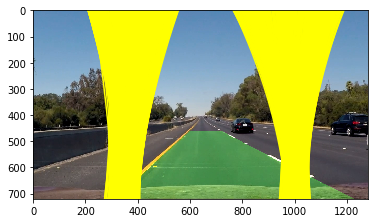

In [148]:
white_output = 'output_video/project_video_output_trial10_red_channel_all.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


In [149]:
##Code to Store video in frames

#import cv2
vidcap = cv2.VideoCapture('./output_video/project_video_output_trial10_red_channel_all.mp4')
success,image = vidcap.read()
count = 0
success = True
while success:
    success,image = vidcap.read()
    print('Read a new frame: ', success)
    cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
    count += 1

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame